# 导入

## 导入包
这些是机器学习最常用的包, 值得系统学习:
* numpy
* pandas
* matplotlib
* seaborn
* scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("Set2")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 定义绘图函数
* 为了方便对所有特征进行比较, 建议对连续型特征进行离散化后, 也用这个绘图函数.

In [2]:
def plot_category(df, feature, group=None):
    """
    对1个或者2个类别特征进行绘图
    返回两张子图:
    第一张是各个level的样本个数
    第二张是各个level下的生存率, 以及95%置信区间
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    sns.countplot(x=feature, hue=group, data=df, ax=ax0)
    sns.barplot(x=feature, y="Survived", hue=group, data=df, ax=ax1)
    ax1.hlines(
        Survived_avg,
        -0.5,
        df[feature].nunique() - 0.5,
        colors="red",
        linestyles="dashed",
    )
    if not group:
        plt.suptitle(feature)
    else:
        plt.suptitle(feature + " | " + group)


## 导入数据

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df = pd.concat([df_train, df_test]).reset_index().drop(["index"], axis=1)
n_train = df_train.shape[0]
n_all = df.shape[0]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 关于字段
* PassengerId: 整数编号, 对于没有什么用, 仍然保留它, 如果以后样本打乱顺序, 可以通过它来快速定位.
* Survived: 因变量, 训练集里面都是0或者1, 表示是否生存, 测试集里面都是NaN

##### 特征:
* Pclass: 表示阶层, 越小表示阶层越高, 从生存率高低或者Fare的平均值高低可以看出这一点.
* Sex: 性别, "女士孩子优先"原则让性别对生存率影响较大.
* Age: 年龄, "女士孩子优先"原则应该会让未成年人的生存率提高, 其他各个年龄段的生存率是否不同呢?
* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* Embarked: 上船地点.

##### 粗粗看起来没有什么用处, 但是, 如果考虑与其他乘客之间的关系的话, 对预测生死有可能有帮助的特征:
* Name: 姓名好像无法决定生死
* Ticket: 船票号码
* Cabin: 船舱号码
* SibSp: 兄弟姐妹或者配偶的个数
* Parch: 父母或者孩子的个数

## 关于因变量(Survived)

In [4]:
Survived_avg = np.around(df.Survived.mean(), decimals=2)
print(f"平均生存率: {Survived_avg}")

平均生存率: 0.38


* 发现生或死比例并不是太悬殊, 否则的话, 要重点考虑类别平衡的问题了.
* 这个平均生存率是比较重要的, 记住这个数字, 后面会多次用到

## 观察缺失值

In [5]:
df.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

* Survived缺失的都是测试集的部分
* Cabin, Age缺失比较严重, 如果一定要使用它们, 需要比较谨慎, 后来发现它们并不重要, 没有使用上.
* Embarked, Fare缺失较少

# EDA

## 新特征: Title

* "女士和孩子优先"原则下, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可
* "女士和孩子优先"原则下, 男孩有必要从男性中分离出来, 男孩称为"boy", 成年男性称为"man"
* 为了和原先的特征"Sex"作区分, 称为"Title", 这两个特征的信息量是有比较大的重叠的, 可以考虑保留其中一个.

In [6]:
df["Title"] = "man"
df.loc[df.Sex == "female", "Title"] = "woman"
df.loc[df["Name"].str.contains("Master"), "Title"] = "boy"
df.Title.value_counts(normalize=True)

man      0.597403
woman    0.355997
boy      0.046600
Name: Title, dtype: float64

* man占了59.7%左右, woman占了35.6%左右, 男孩占了4.7%左右.
* 后面会发现这个占比很重要, man的占比很大, 但难以预测出幸存者, 这就是为什么最高分(83%左右)难以超出基准分(性别模型, 76.6%)太多的主要原因.

### 可视化

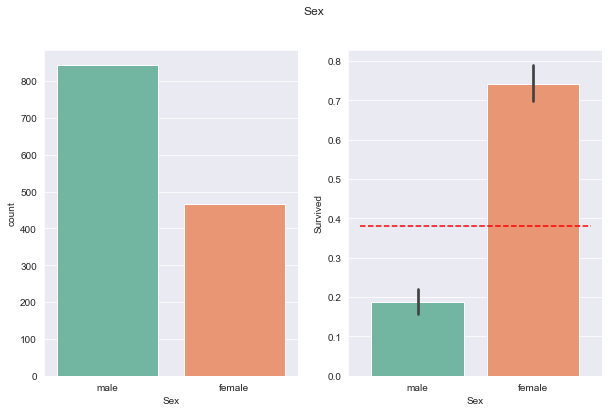

In [7]:
plot_category(df, "Sex")

* 发现male生存率远远低于平均值, female生存率远远高于平均值, 这就是为什么简单的"gender model", 正确率就高达76.6%的原因.

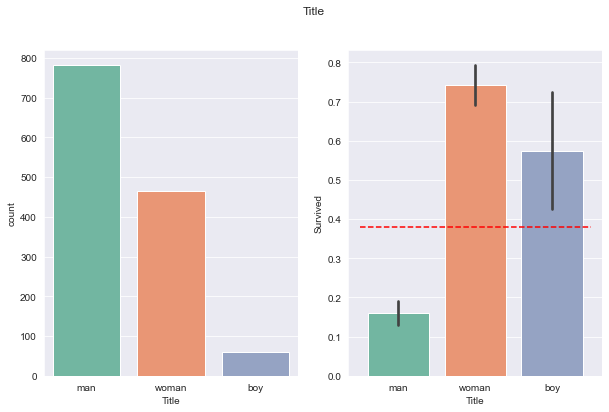

In [8]:
plot_category(df, "Title")

* 发现boy虽然也是男性, 但是生存率与man截然不同, man生存率不到20%, 而boy生存率接近60%
* 说明对男性分成细分成两类, 是有价值的
* 有遗憾的地方在于: boy的占比太小了, 对整体成绩的提升非常有限(理论上, 准确率最多提高4.7%左右)

### 为了保险起见, 验证一下: "不需要特别分离出女孩了, 女孩和成年女性分为一类即可"
* 假设14岁以及以下, 是女孩, 14岁以及以上, 是成年女性

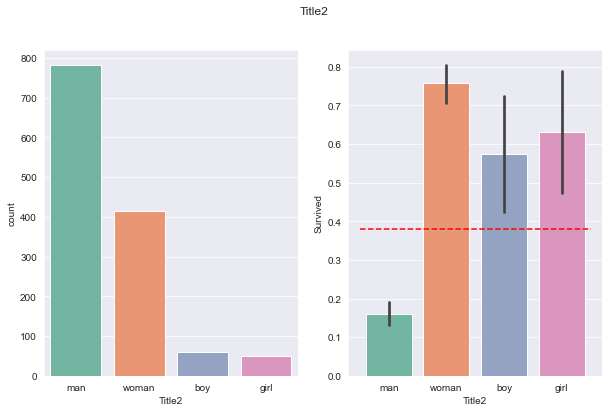

In [9]:
df["Title2"] = df["Title"]
df.loc[(df.Title == "woman") & (df.Age <= 14), "Title2"] = "girl"
plot_category(df, "Title2")
del df["Title2"]

* 发现woman与girl的生存率并没有显著差别, 因此, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可

## 新特征: Pfare

* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* 因此, Fare是一个交叉性特征, 同时考虑了平均价格和一张票的乘客数量
* 对Fare这个特征进行"提纯", 求平均价格(Pfare), 平均价格更能体现出乘客的地位, 从而反映在生存率上.

In [10]:
df.Fare.replace(0, np.NaN, inplace=True)
df["Pfare"] = df["Fare"] / df.groupby("Ticket")["Ticket"].transform("count")

### 可视化

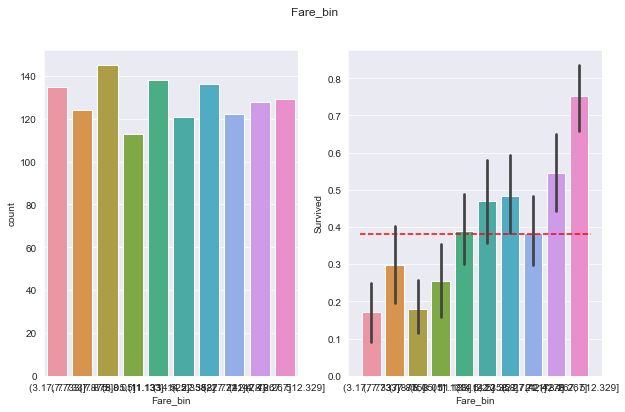

In [11]:
df["Fare_bin"] = pd.qcut(df["Fare"], 10)
plot_category(df, "Fare_bin")

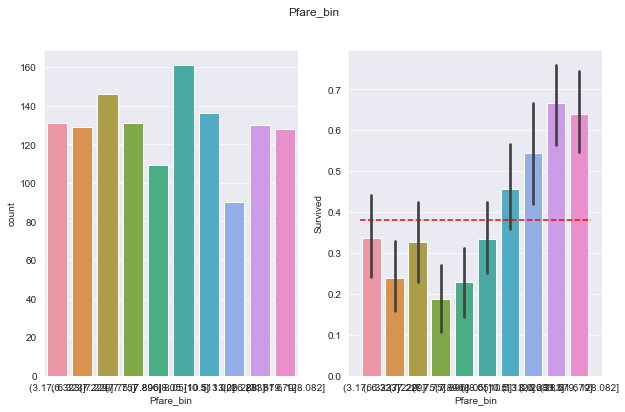

In [12]:
df["Pfare_bin"] = pd.qcut(df["Pfare"], 10)
plot_category(df, "Pfare_bin")

* 对比Fare与Pfare的图形, 发现Pfare的单调性更好.

## Pclass

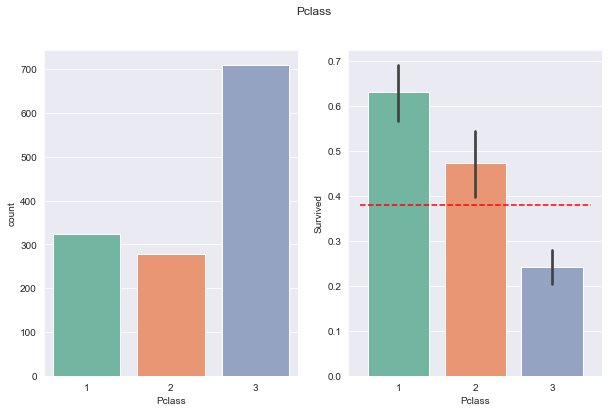

In [13]:
plot_category(df, "Pclass")

* 发现等级越高, 生存率越高, 符合预期

## Age

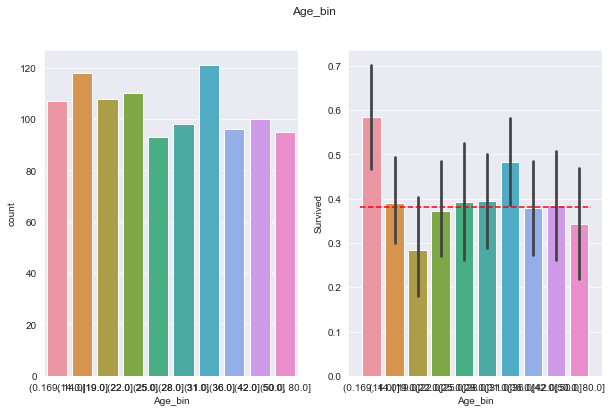

In [14]:
df["Age_bin"] = pd.qcut(df["Age"], 10)
plot_category(df, "Age_bin")

* 除了第一个区间(低年龄段), 其他区间的生存率都在平均生存率附近
* 但是低年龄段已经通过Title体现过了
* 因此, Age很可能是信息量低的特征, 可以考虑舍掉.

## SibSp

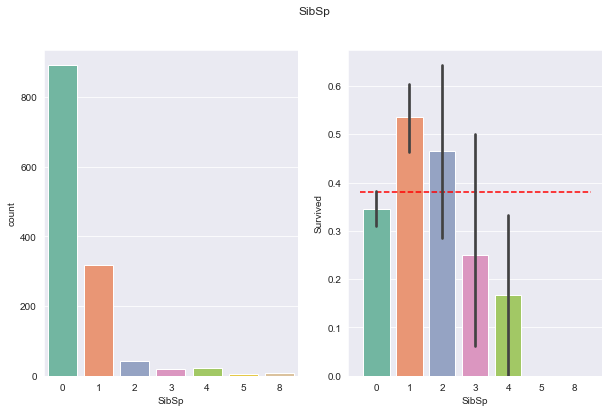

In [15]:
plot_category(df, "SibSp")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 平均值附近
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Parch

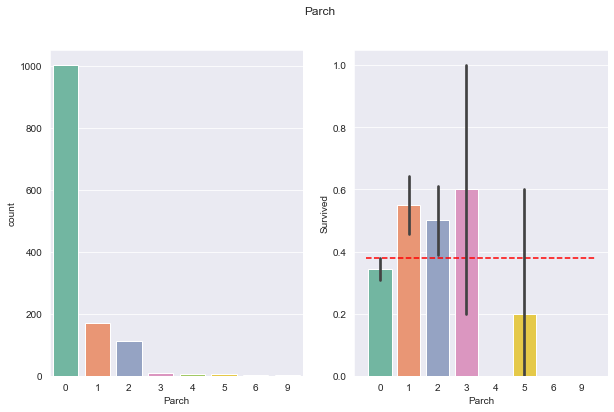

In [16]:
plot_category(df, "Parch")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Family

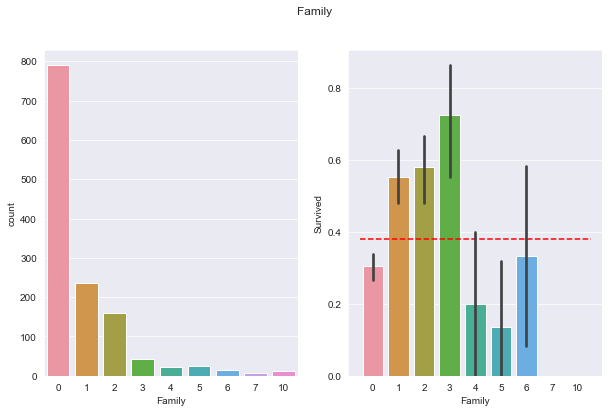

In [17]:
df["Family"] = df.SibSp + df.Parch
plot_category(df, "Family")

* 当为0时, 稍微低于平均值
* 当为1或2或3时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性, 但是比SibSp, Parch都要强.

## Embarked

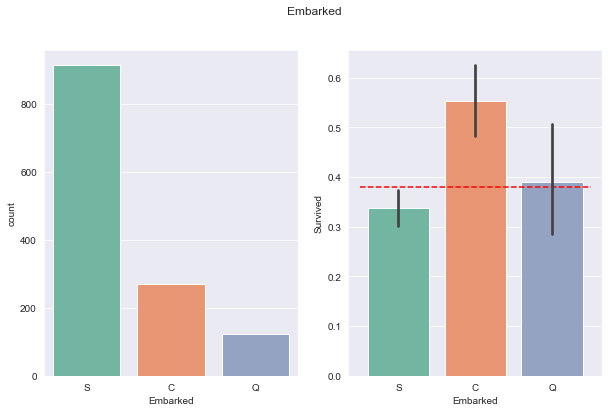

In [18]:
plot_category(df, "Embarked")

* 取值为C时, 高于平均值
* 取值为S时, 低于平均值
* 取值为Q时, 在平均值附近
* 总体来看, 是中等预测能力的特征.

## 单个特征的预测能力排名:
#### 基于图形主观判断

#### 强预测能力特征:
* Title, Sex
* Pclass
* Pfare

#### 中预测能力特征:
* Embarked

#### 弱预测能力特征:
* Family, Parch, SibSp

#### 无预测能力特征:
* Age


下文中, 不再去考虑Family, Parch, SibSp, 因为这些都是家庭因素, WCG模型也是考虑家庭因素, 而且巧妙得多.

也不会考虑Age.

Title是目前最强的特征, 而且后面的WCG模型和"Voting of KNN"模型也是根据Title进行分治的.

因此, 后面的交叉特征必须要有Title, 没有Title的交叉特征不考虑.

## Title与Pclass交叉

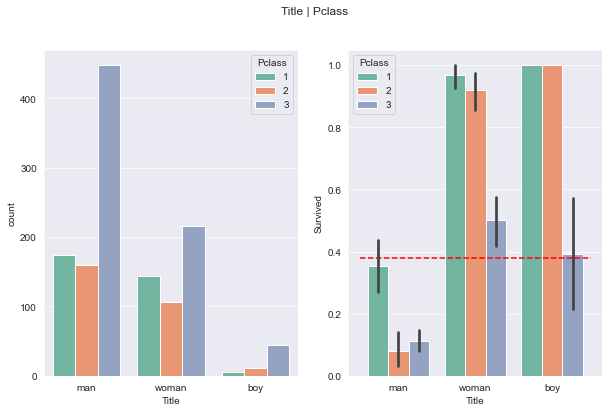

In [19]:
plot_category(df, "Title", group="Pclass")

* man不管是什么Pclass, 都无法达到平均生存率, Pclass == 1的man稍低于平均生存率
* woman不管是什么Pclass, 都超过了平均生存率, Pclass == 3的woman稍高于平均生存率
* boy不管是什么Pclass, 都超过了平均生存率, Pclass == 3的boy接近于平均生存率

## Title与Pfare交叉

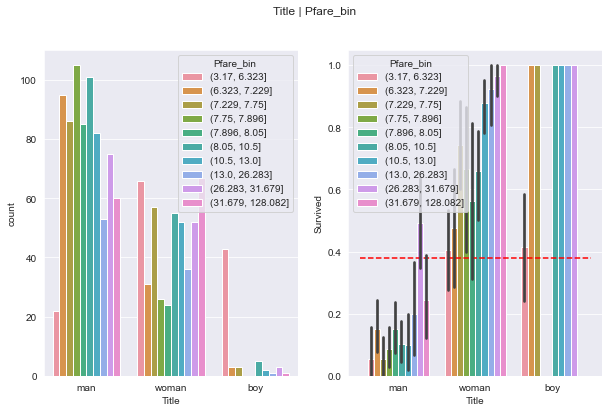

In [20]:
plot_category(df, "Title", group="Pfare_bin")

* 对于man, 第2高档的Pfare的生存率接近于平均值.
* 对于woman或boy, 最低档的Pfare的生存率在平均值附近.

## Title与Embarked交叉

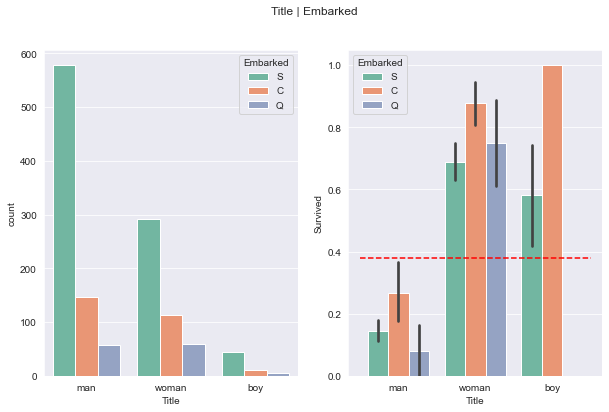

In [21]:
plot_category(df, "Title", group="Embarked")

* Embarked == Q的boy, 生存率为0%, 可能是有偶然性的, 因为这样的样本太少.
* 其他的group形状符合预期.

In [22]:
df.loc[(df.Title == "boy") & (df.Embarked == "Q")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family
16,17,0.0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
171,172,0.0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
278,279,0.0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
787,788,0.0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
946,947,NaN,3,"Rice, Master. Albert",male,10.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5


* 发现Embarked == Q的boy应该是在自于同一个家庭(成为"Rice"家庭), 同一个家庭出现同生同死的概率相当大(下文中会验证这一点), 不巧的是, 这个家庭正好落在了"同死"这个状态.

## Title, Pclass, Pfare交叉

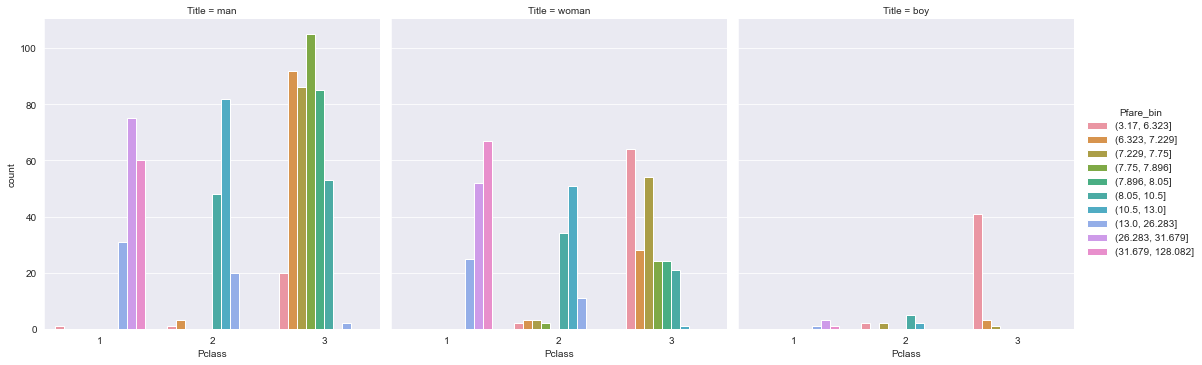

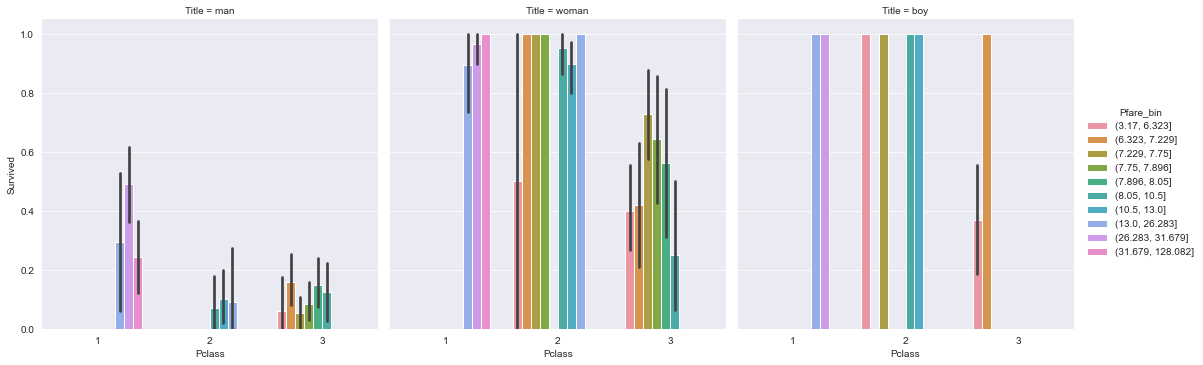

In [23]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, 第2高档的Pfare, 生存率接近平均值
* 对于woman或者boy, Pclass == 3, 最低档的Pfare, 生存率接近平均值

## Title, Pclass, Embarked交叉

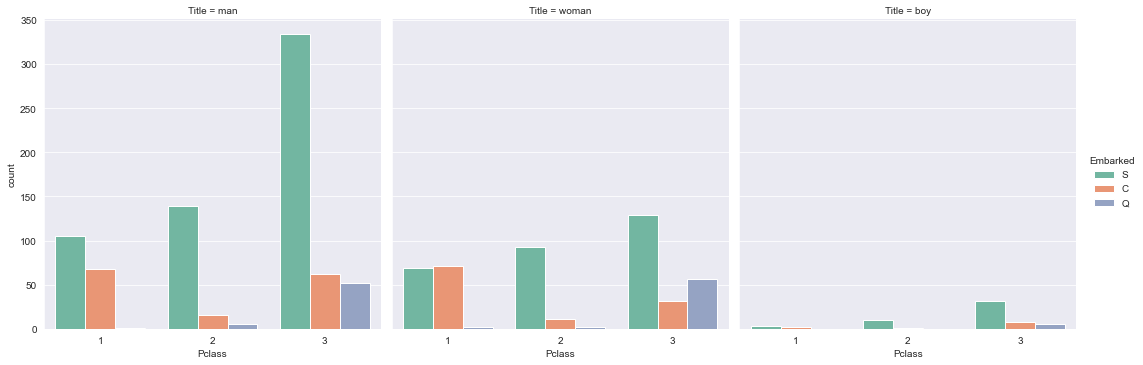

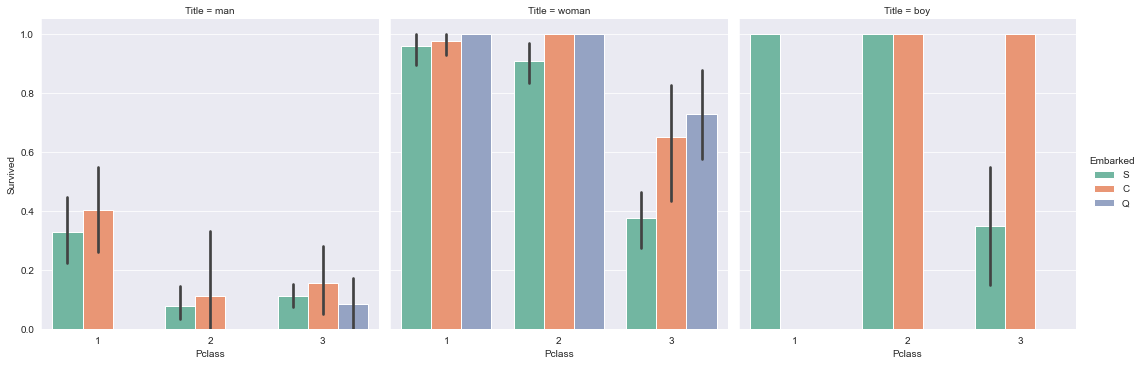

In [24]:
sns.catplot(x="Pclass", y=None, hue="Embarked", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Embarked", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, 生存率接近平均值
* 对于woman或者boy, Pclass == 3, Embarked == S, 生存率接近平均值

## Title, Pfare, Embarked交叉

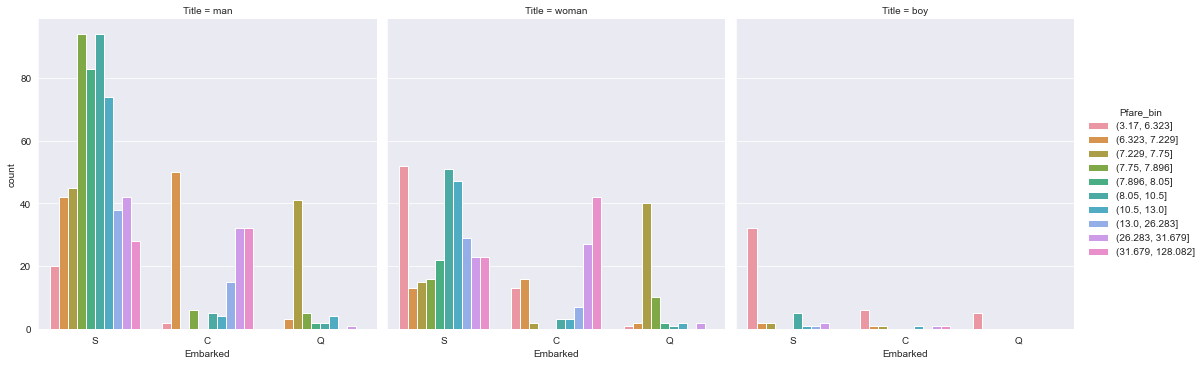

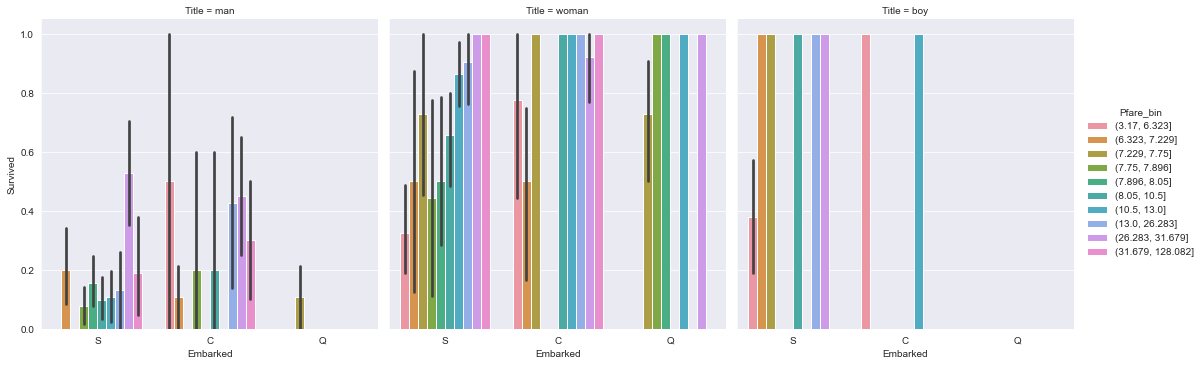

In [25]:
sns.catplot(x="Embarked", y=None, hue="Pfare_bin", col="Title", data=df, kind="count")
sns.catplot(x="Embarked", y="Survived", hue="Pfare_bin", col="Title", data=df, kind="bar")

* 对于man, 在Embarked == S, 第2高Pfare档位, 生存率接近于平均值
* 对于woman, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值
* 对于boy, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值

## Title, Pclass, Pfare, Embarked交叉

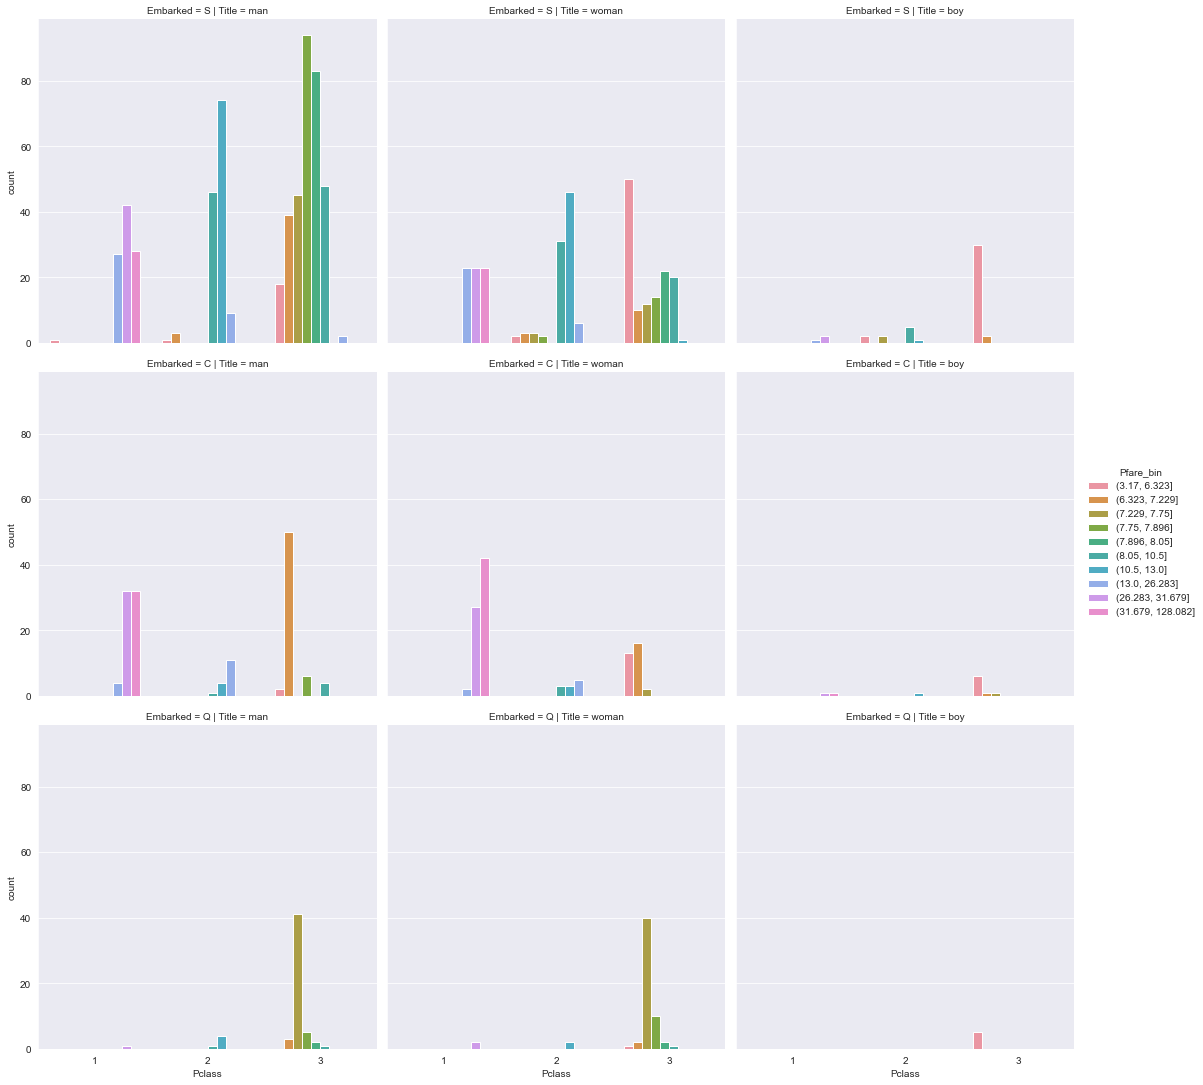

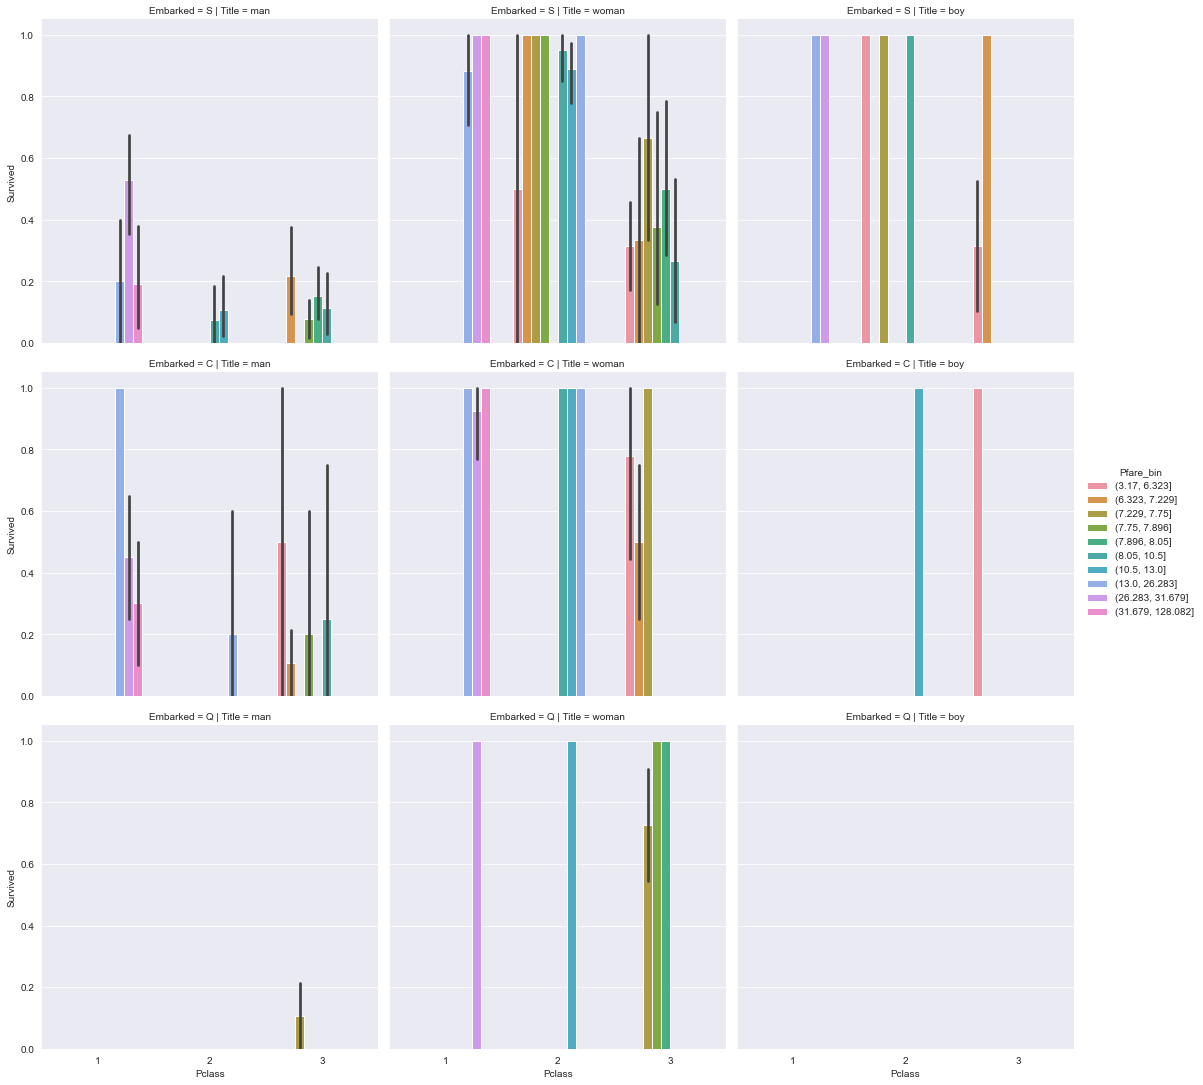

In [26]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
* 对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值

## 小结
* 对于单个特征进行了排名, 对特征的预测能力有个总体的判断
* 使用二重交叉特征, 三重交叉特征, 四重交叉特征, 对于发现那些异常情况非常有帮助.
* 发现二重交叉特征, 三重交叉特征的异常情况是和四重交叉特征的异常情况不矛盾的, 是一致的.
* 因此, 只保留下四重交叉特征的异常情况:
* 对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
* 对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 还有一些小样本的情况.

In [27]:
df.loc[(df.Title == "man") 
       & (df.Pclass == 1)
       & (df.Embarked.isin(["S"])) 
       & (26.832 < df.Pfare) 
       & (df.Pfare <= 31.679),
       "Survived"].mean()

0.5833333333333334

In [28]:
df.loc[(df.Title == "woman") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"]))
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3142857142857143

In [29]:
df.loc[(df.Title == "boy") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"])) 
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3157894736842105

* 验证了上面说的三种异常情况.
* 对于man的异常情况, 生存率是58%, 虽然高于平均生存率(38%), 但是只比50%高一点点.
* 对于woman或者boy的异常情况, 生存率分为了31.4%, 31.6%, 如果预测他们为死亡, 看起来不错.
* 但是, 并不打算选择直接使用交叉特征做预测, 原因:
1. 3种异常情况的样本并不太多, 而且准确率也不算高, 因此, 总体准确率不会提高太多.
2. 有过拟的风险, 准确率要进一步下调.
3. 想法比较naive, 没有用到任何机器学习模型.
4. 并不好评估泛化能力.

* 虽然不能做出预测, 但是, 对各个特征以及它们之间的交叉情况有了非常直观的了解, 为以后的建模, 打下了基础, 比如:
1. Title是目前发现的最重要特征, 下文中, 对样本的分治以Title为主.
2. Pclass是目前发现第二重要的特征.
3. Pfare是目前发现第三重要的特征.
4. Embarked是目前发现第四重要的特征, 发现的三种异常情况都是在"S"上. 当然, 还有一些小样本情况.

# WCG模型

* WCG模型是本文中最核心, 最精彩的部分
* WCG模型不是我的想到的, 当然, 并不是因为我太菜了, 而是对于任何一个人来说, 都是难以想到的.
* WCG模型难以想到的原因:
1. Name一般会被想当然的认为类似Id的东西, 很有可能直接删除掉了, 不会想到去分析它.
2. 家庭成员个数不超过11个, 统计家庭存活率一般会被认为是过拟的.
3. 统计家庭存活率的时候, 将man剔除出去, 这个比较难想到的.
4. 考虑到可能存在女保姆这类群体.
* 每一条都至少淘汰90%的人, 单个人同时考虑到以上4条的, 概率是万中无一.
* 还好Kaggle可以分享的, 不断有人在其他人工作的基础上做出更多的努力, 逐渐凑齐了这4条, WCG模型属于Kaggle社区的**集体智慧**

## WCG模型的核心概念: Woman-Child-Groups (WCG)
* 注意, WCG不同于WCG模型, WCG是一种分组方法, WCG模型是基于WCG的预测模型.
* WCG用一句话来概括, 就是: 将一个家庭内的所有女性(包括女保姆)或孩子认定为一组.
* 需要特别留意的是: 一个家庭内的成年男性并没有分到组里面.
* 这背后的逻辑是: 
1. 一个家庭内的成员活动在一起, 同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死.
2. 男人因为"女士和孩子优先"这条规则, 并不遵循第1条逻辑.
3. 虽然传统意义上, 女保姆不算是家庭成员, 但是女保姆和东家活动在一起, 也符合"女士和孩子优先"这条规则的, 因此, 女保姆的生存率和东家的女生孩子的生存率应该是没有任何区别的.

### WCG组号(GroupId)的计算方法: **GroupId = Surname + Pclass + Ticket(舍掉最后一位) + Fare + Embarked**
* 一家人就应该有相同的Surname, 和中国不同, 很多国家女性嫁人以后, 就随丈夫的姓氏.
* 一家人应该是相同的阶层.
* 一家人应该是使用相同的船票.
* 其中Ticket舍掉最后一位, 因为发现有些实际上是一家人, 但是Ticket最后一位不同(这种情况并不多见, 发现这种现象的人观察力惊人!)
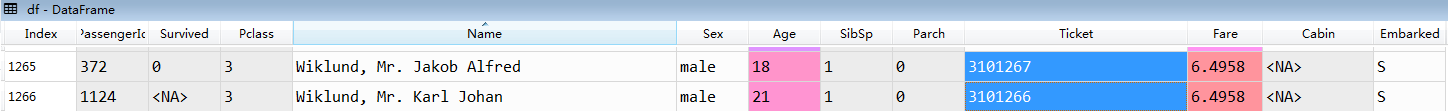

* 因为舍掉了最后一位, 有可能两张不同Ticket被认为是相同的Ticket了, 因此, 需要Fare, Embarked来进一步确认.
* 这个公式里面, 没用Cabin, 有两个理由:
1. Cabin与Ticket信息是有冗余的.
2. Cabin的缺失率太高了.
3. 如果家庭成员的人数较多, 有可能分在了不同Cabin里面.


* 关于GroupId的后续处理(修正方法):
1. 将所有的man的GroupId赋值为"noGroup", 因为前面提到了, man并不属于任何WCG.
2. 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup", 逻辑很简单, 单独一个人, 不能算是一个"Group", 
   另外, 对于预测毫无用处, 单独一个人无法用来预测其他乘客的生死.
3. 将女保姆的GroupId改为东家的GroupId, 关于女保姆的认定方法会在下文中细讲.

In [30]:
df["Surname"] = df["Name"].str.split(",").str[0]

df["Ticket_id"] = (
    df.Pclass.astype(str)
    + "-"
    + df.Ticket.str[:-1].astype(str)
    + "-"
    + df.Fare.astype(str)
    + "-"
    + df.Embarked.astype(str)
)

df["Group_id"] = df.Surname + "-" + df["Ticket_id"]

# 后续处理
df.loc[df.Title == "man", "Group_id"] = "noGroup"
df["WC_count"] = (
    df.loc[df.Title != "man"]
    .groupby("Group_id")["Group_id"]
    .transform("count")
)
df.loc[df.WC_count <= 1, "Group_id"] = "noGroup"

### 女保姆的认定
* 注意: 女保姆只是对一类人的称呼, 并不能保证一定是这样的职业, 是不是这样的职业, 不影响预测.

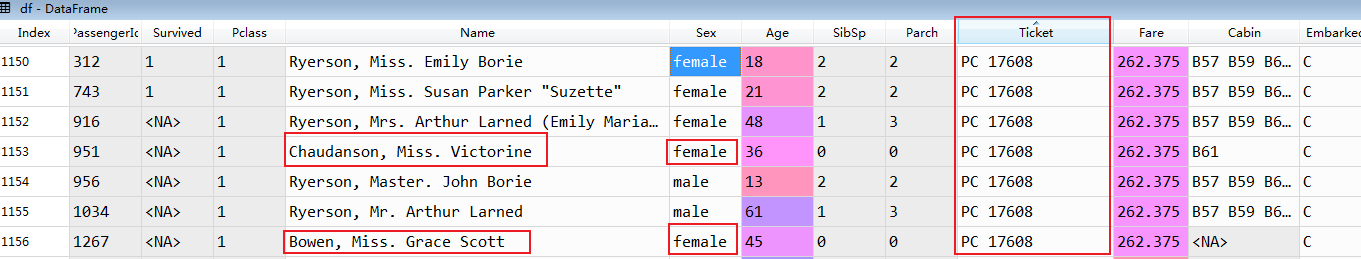

* 红框圈出来的两个人, 发现除了Surname不符合GroupId的标准, 其他都符合.

* 定义一个新的组号(不是WCG的组号, 仅仅用来辅助认定女保姆的): **TicketId = Pclass + Ticket(舍掉最后一位) + Fare + Embarked**

* 女保姆的认定标准:
1. 不能是man, 因为WCG以及排除掉man了, 理论上有可能是boy, 实际发现找出来的都是woman, 这是将这类人命名为"女保姆"的原因之一.
2. GroupId为"noGroup", 即, 假设女保姆是单独一人(女保姆在船上没有家人)和东家在一起.
3. 存在与该样本TicketId相同的WCG(东家的GroupId不能为"noGroup")

* 认定为女保姆以后, 将该样本的GroupId(原先为"noGroup")修正为东家的GroupId, 即女保姆算是东家的成员.


**思考**: 
* 前面对GroupId的后续处理中, 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup"(下文中简称为"规则2"), 
* 基于女保姆的认定标准3, 意味着如果东家是一个人的话, 女保姆不会被认定为女保姆.
* 那么, 规则2是不是有合理性呢?
* 答案是有合理性.
* 因为规则2虽然会造成"如果东家是一个人的话, 女保姆不会被认定为女保姆", 
* 但是更多的避免了"两个乘客恰好只是同票, 实际上没有任何关系, 既不是同一个家庭, 也不是东家与女保姆的关系".
* 规则2要求家庭成员至少是2个, 那么那个"异姓"的是女保姆的概率就非常大了, 如果家庭成员只有1个, 那个"异姓"的是女保姆的概率比较小.

In [31]:
indices = []
count = 0
for i in range(n_all):
    if df.loc[i, "Title"] != "man" and df.loc[i, "Group_id"] == "noGroup":
        idx = np.flatnonzero(
            (df["Ticket_id"] == df.loc[i, "Ticket_id"])
            & (df["Group_id"] != "noGroup")
        )
        if len(idx):
            df.loc[i, "Group_id"] = df.loc[idx[0], "Group_id"]
            indices.append(i)
            count += 1
print(f"发现了{count}个女保姆")
df.loc[indices]

发现了11个女保姆


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count
337,338,1.0,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.5000,E40,C,woman,26.900000,"(78.267, 512.329]","(26.283, 31.679]","(36.0, 42.0]",0,Burns,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
708,709,1.0,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(19.0, 22.0]",0,Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
950,951,NaN,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,PC 17608,262.3750,B61,C,woman,37.482143,"(78.267, 512.329]","(31.679, 128.082]","(31.0, 36.0]",0,Chaudanson,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0
1032,1033,NaN,1,"Daniels, Miss. Sarah",female,33.0,0,0,113781,151.5500,NaN,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(31.0, 36.0]",0,Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
1067,1068,NaN,2,"Sincock, Miss. Maude",female,20.0,0,0,C.A. 33112,36.7500,NaN,S,woman,9.187500,"(27.721, 42.4]","(8.05, 10.5]","(19.0, 22.0]",0,Sincock,2-C.A. 3311-36.75-S,Davies-2-C.A. 3311-36.75-S,1.0
1140,1141,NaN,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C,woman,7.227100,"(11.133, 14.5]","(6.323, 7.229]",NaN,1,Khalil,3-266-14.4542-C,Zabour-3-266-14.4542-C,1.0
1171,1172,NaN,3,"Oreskovic, Miss. Jelka",female,23.0,0,0,315085,8.6625,NaN,S,woman,8.662500,"(8.05, 11.133]","(8.05, 10.5]","(22.0, 25.0]",0,Oreskovic,3-31508-8.6625-S,Cacic-3-31508-8.6625-S,1.0
1258,1259,NaN,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",female,22.0,0,0,3101295,39.6875,NaN,S,woman,5.669643,"(27.721, 42.4]","(3.17, 6.323]","(19.0, 22.0]",0,Riihivouri,3-310129-39.6875-S,Panula-3-310129-39.6875-S,1.0
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",female,31.0,0,0,16966,134.5000,E39 E41,C,woman,26.900000,"(78.267, 512.329]","(26.283, 31.679]","(28.0, 31.0]",0,Wilson,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
1266,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,PC 17608,262.3750,NaN,C,woman,37.482143,"(78.267, 512.329]","(31.679, 128.082]","(42.0, 50.0]",0,Bowen,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0


* 发现这11个女保姆里面, 有9个是测试集里面的, 最多可以提高成绩9/418=2.15%, 说明发现女保姆的努力是有价值的.
* 下文可以发现, 其中3个女保姆被预测死亡, 分别是索引号为1140, 1171, 1258, 她们的Pclass都为3, 其他都被预测为生存, 她们的Pclass都为1或2.

## 非WCG乘客("noGroup")与WCG乘客(非"noGroup")的区别
* 下文中会根据Group_id是否为"noGroup", 对样本进行分治, WCG乘客会用WCG模型进行预测, 非WCG乘客会用"Voting of KNN"模型进行预测
* 在此之前, 有必要说明一下, 这种分治是有必要的.

### Title分布比较

In [32]:
print(f"非WCG组号个数: {df.Group_id.loc[lambda x: x == 'noGroup'].nunique()}")
print(f"WCG组号个数: {df.Group_id.loc[lambda x: x != 'noGroup'].nunique()}")

print()
print(f"非WCG乘客个数: {df.Group_id.loc[lambda x: x == 'noGroup'].count()}")

print()
print(f"WCG乘客个数: {df.Group_id.loc[lambda x: x != 'noGroup'].count()}")

print()
print("非WCG乘客的Title分布:")
print(df.loc[df.Group_id == "noGroup", "Title"].value_counts())

print()
print("WCG乘客的Title分布:")
print(df.loc[df.Group_id != "noGroup", "Title"].value_counts())

print()
print("全体乘客的Title分布:")
print(df.Title.value_counts())

print()
print("非WCG覆盖率:")
print((df.loc[df.Group_id == "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

print()
print("WCG覆盖率:")
print((df.loc[df.Group_id != "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

非WCG组号个数: 1
WCG组号个数: 80

非WCG乘客个数: 1079

WCG乘客个数: 230

非WCG乘客的Title分布:
man      782
woman    295
boy        2
Name: Title, dtype: int64

WCG乘客的Title分布:
woman    171
boy       59
Name: Title, dtype: int64

全体乘客的Title分布:
man      782
woman    466
boy       61
Name: Title, dtype: int64

非WCG覆盖率:
man      1.000000
woman    0.633047
boy      0.032787
Name: Title, dtype: float64

WCG覆盖率:
boy      0.967213
man      0.000000
woman    0.366953
Name: Title, dtype: float64


* 大约有96.7%的boy是WCG成员.
* 大约有36.7%的woman是WCG成员.
* 没有man是WCG成员.

### 生存率的区别

In [33]:
df.loc[(df.Title == "man") & (df.Group_id == "noGroup"), "Survived"].mean()

0.1601489757914339

In [34]:
df.loc[(df.Title == "man") & (df.Group_id != "noGroup"), "Survived"].mean()

nan

In [35]:
df.loc[(df.Title == "man") & (df.Group_id != "noGroup")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count


In [36]:
df.loc[(df.Title == "boy") & (df.Group_id == "noGroup"), "Survived"].mean()

nan

In [37]:
df.loc[(df.Title == "boy") & (df.Group_id == "noGroup")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count
912,913,NaN,3,"Olsen, Master. Artur Karl",male,9.0,0,1,C 17368,3.1708,NaN,S,boy,3.1708,"(3.17, 7.733]","(3.17, 6.323]","(0.169, 14.0]",1,Olsen,3-C 1736-3.1708-S,noGroup,1.0
1230,1231,NaN,3,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C,boy,7.2292,"(3.17, 7.733]","(6.323, 7.229]",NaN,0,Betros,3-262-7.2292-C,noGroup,1.0


* 只有两个样本, 根据之前的四重交叉特征分析, 全部都死亡的概率比较大.

In [38]:
df.loc[(df.Title == "boy") & (df.Group_id != "noGroup"), "Survived"].mean()

0.575

In [39]:
df.loc[(df.Title == "woman") & (df.Group_id == "noGroup"), "Survived"].mean()

0.8181818181818182

In [40]:
df.loc[(df.Title == "woman") & (df.Group_id != "noGroup"), "Survived"].mean()

0.6120689655172413

* 令人吃惊的是: 单身woman比非单身woman的生存率高出了将近20%, 是因为单身woman行动更灵活方便?

### 小结
* 非WCG乘客与WCG乘客的分布是相差比较大的.
* 非WCG乘客与WCG乘客的各个Title生存率也是相差比较大的.
* 因此, 这种分治, 是有必要的.

## 组内生存率
* 发现一个家庭内的成员同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死.

In [41]:
df["WCSurvived"] = df.loc[df.Group_id != "noGroup"].groupby("Group_id").Survived.transform("mean")

### 组内生存率的分布

In [42]:
print("组内生存率的分布:")
print(df.WCSurvived.value_counts(dropna=False))

组内生存率的分布:
NaN     1088
1.00     134
0.00      76
0.75       6
0.50       5
Name: WCSurvived, dtype: int64


* 发现组内生存率大部分是0.0或者1.0, 即同生同死的概率非常大, 组内生存率的预测能力比以往发现的任何特征都更强!

In [43]:
df.loc[df.WCSurvived == 0.75]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived
25,26,1.0,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,woman,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(36.0, 42.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
182,183,0.0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S,boy,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
233,234,1.0,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S,woman,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
261,262,1.0,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,boy,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1045,1046,NaN,3,"Asplund, Master. Filip Oscar",male,13.0,4,2,347077,31.3875,NaN,S,boy,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1270,1271,NaN,3,"Asplund, Master. Carl Edgar",male,5.0,4,2,347077,31.3875,NaN,S,boy,4.483929,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",6,Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75


* 组内生存率为0.75, 但是:
* Pclass == 3, Pfare处在最低档, Embarked == "S", 这种情况属于之前发现的boy大概率死亡的情况.

In [44]:
df.loc[df.WCSurvived == 0.5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived
297,298,0.0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(0.169, 14.0]",3,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
305,306,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,boy,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(0.169, 14.0]",3,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
498,499,0.0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(22.0, 25.0]",3,Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
708,709,1.0,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,NaN,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(19.0, 22.0]",0,Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5
1032,1033,NaN,1,"Daniels, Miss. Sarah",female,33.00,0,0,113781,151.55,NaN,S,woman,25.258333,"(78.267, 512.329]","(13.0, 26.283]","(31.0, 36.0]",0,Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5


* 组内生存率为0.5, 但是:
* Pclass == 1, Pfare处在较高档, 这种情况属于之前发现的woman大概率生存的情况.

### 找出哪些组是全部成员都在测试集里面的:

* 前面提到了"如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死"
* 但是, 如果一个组内的全部成员都在测试集里面, 又该如何?

In [45]:
groups_test = set(df[n_train:].Group_id.unique()) - set(df[:n_train].Group_id.unique())
df.loc[df.Group_id.isin(groups_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45.00,0,1,112378,59.4000,NaN,C,woman,29.700000,"(42.4, 78.267]","(26.283, 31.679]","(42.0, 50.0]",1,Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.00,0,1,112378,59.4000,NaN,C,woman,29.700000,"(42.4, 78.267]","(26.283, 31.679]","(19.0, 22.0]",1,Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.00,0,2,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(31.0, 36.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",female,1.00,1,1,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26.00,0,2,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(25.0, 28.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,boy,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.00,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1083,1084,NaN,3,"van Billiard, Master. Walter John",male,11.50,1,1,A/5. 851,14.5000,NaN,S,boy,4.833333,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN
1235,1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,boy,4.833333,"(11.133, 14.5]","(3.17, 6.323]",NaN,2,van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN


* 全部成员都在测试集里的家族有: Gibson, Klasen, Peacock, van Billiard.
* Gibson家族的      Pclass == 1, Pfare == 29.7(第9档), Embarked == "C", Title == "woman"
* Klasen家族的      Pclass == 3, Pfare == 6.09(第1档), Embarked == "S", Title == "woman"
* Peacock家族的     Pclass == 3, Pfare == 4.59(第1档), Embarked == "S", Title == "woman"(2个woman, 1个boy, 算做woman, 因为同生同死, 少数服从多数)
* van Billiard家族的Pclass == 3, Pfare == 4.83(第1档), Embarked == "S", Title == "boy"

### 利用之前的四重交叉特征对这些家族进行预测:
* 与之前的四重交叉特征分析不同, 之前使用的是全体乘客数据, 这一次, 使用的是WCG乘客数据.

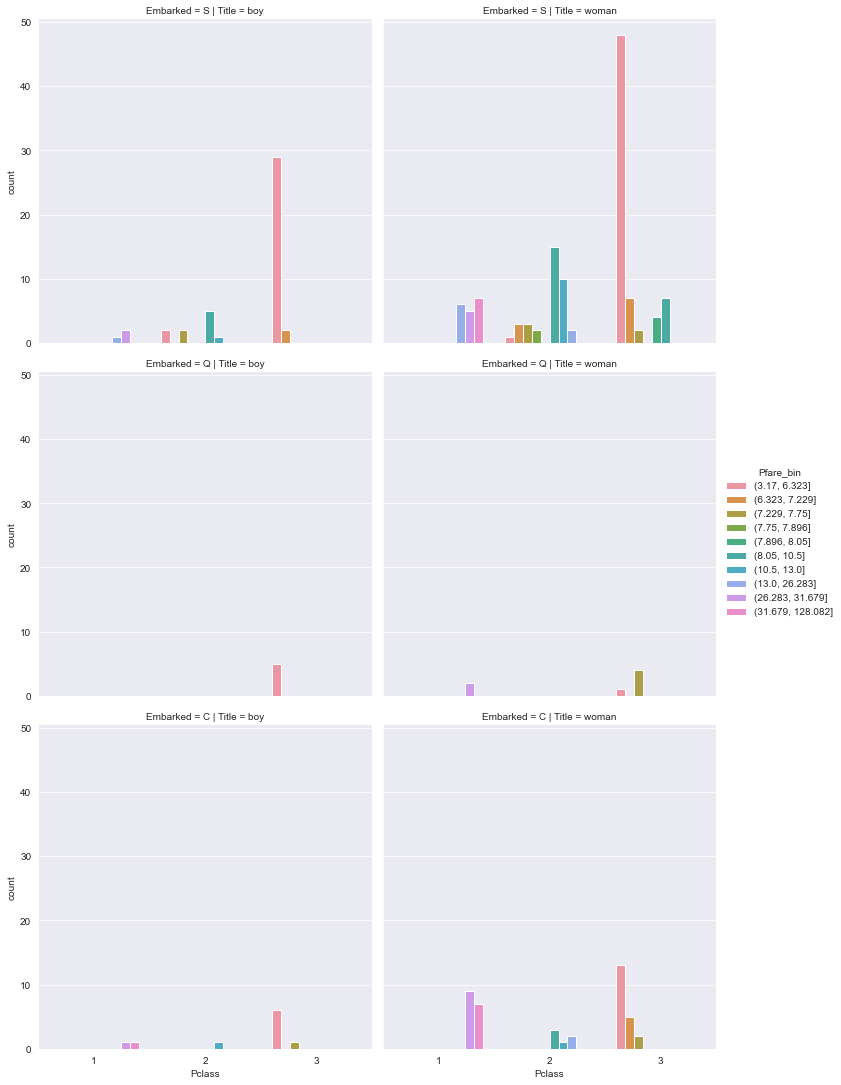

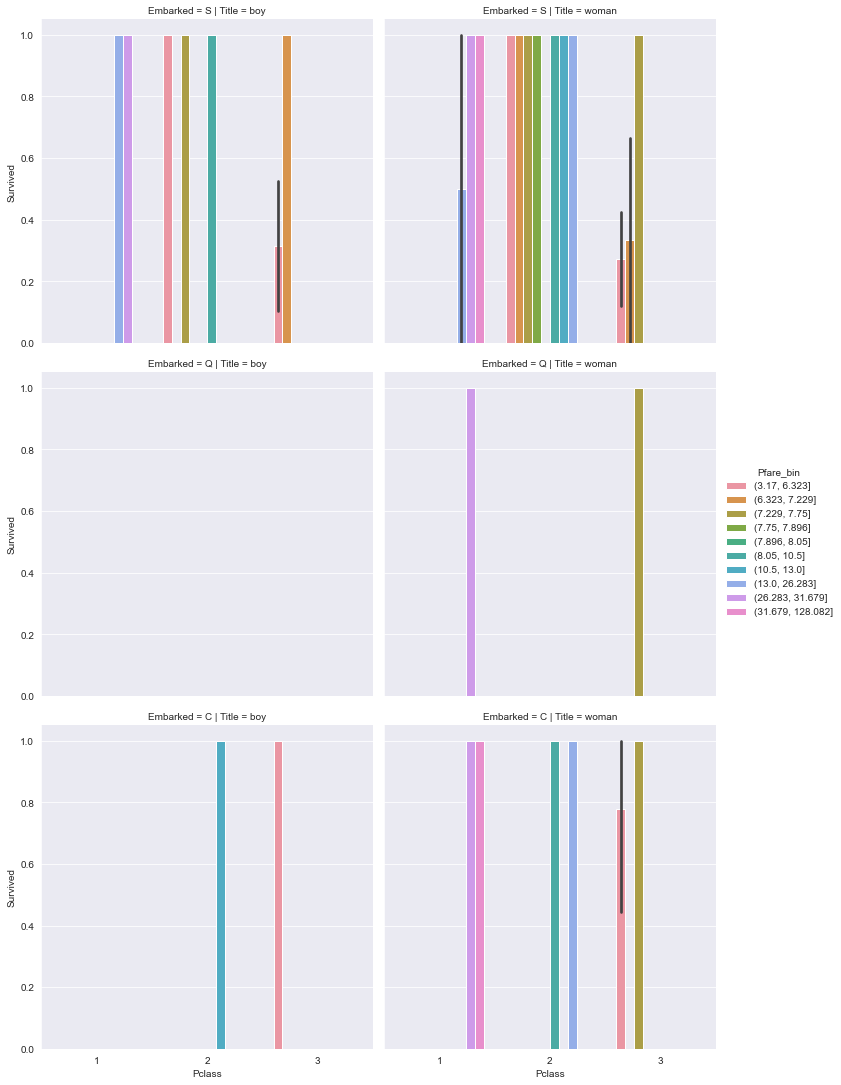

In [46]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="bar")

* 根据四重交叉特征, 发现:
* Gibson家族大概率应该是同生的.
* Klasen, Peacock, van Billiard家族大概率都是同死的.

In [47]:
df.loc[df.Group_id.isin(groups_test), "WCSurvived"] = 0.0
df.loc[df.Surname == "Gibson", "WCSurvived"] = 1.0
df.loc[df.Group_id.isin(groups_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45.00,0,1,112378,59.4000,NaN,C,woman,29.700000,"(42.4, 78.267]","(26.283, 31.679]","(42.0, 50.0]",1,Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.00,0,1,112378,59.4000,NaN,C,woman,29.700000,"(42.4, 78.267]","(26.283, 31.679]","(19.0, 22.0]",1,Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.00,0,2,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(31.0, 36.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",female,1.00,1,1,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26.00,0,2,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(25.0, 28.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,boy,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.00,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1083,1084,NaN,3,"van Billiard, Master. Walter John",male,11.50,1,1,A/5. 851,14.5000,NaN,S,boy,4.833333,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0
1235,1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,boy,4.833333,"(11.133, 14.5]","(3.17, 6.323]",NaN,2,van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0


### 检查WCG乘客是否都有了组内生存率

In [48]:
df.loc[(df.Group_id != "noGroup") & df.WCSurvived.isna()].shape[0]

0

* 是的, WCG乘客都有了组内生存率

## 基于组内生存率, 进行预测
* 如果woman的组内生存率是0%, 那么预测她死亡, 否则, 预测她生存
* 如果乘客是man, 一律预测他死亡.
* 如果boy的组内生存率是100%, 那么预测他生存, 否则, 预测他死亡.

* 背后的逻辑:
* woman的生存率整体上是比较高的, 所以默认预测为生存, 预测她死亡, 需要比较严苛的条件(组内生存率是0%)
* man的生存率整体上是比较低的, 光凭组内生存率, 已经无法预测哪些是幸存者了, 所以, 一律预测为死亡.
* boy的组内生存率如果是100%, 那么预测他生存, 如果是0%, 那么预测他死亡, 这两条没有什么可说的. 除去这两条情况, 测试集总共只剩下4个样本了, 根据分析, 发现这4个样本死亡的概率比较大.

In [52]:
df.loc[n_train : n_all - 1, "Predict"] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Sex == "female")] = 1
df.loc[n_train : n_all - 1, "Predict"][(df.Sex == "female") & (df["WCSurvived"] == 0)] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Title == "boy") & (df["WCSurvived"] == 1)] = 1

### 测试集里面, 被预测为生存的boy:

In [53]:
df_boy_alive = df[n_train:].loc[(df.Title == "boy") & (df.Predict == 1)]
print(f"被预测为生存的boy({df_boy_alive.shape[0]}个):")
df_boy_alive

被预测为生存的boy(8个):


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived,Predict
955,956,NaN,1,"Ryerson, Master. John Borie",male,13.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,boy,37.482143,"(78.267, 512.329]","(31.679, 128.082]","(0.169, 14.0]",4,Ryerson,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,4.0,1.0,1.0
980,981,NaN,2,"Wells, Master. Ralph Lester",male,2.00,1,1,29103,23.0000,NaN,S,boy,7.666667,"(22.358, 27.721]","(7.229, 7.75]","(0.169, 14.0]",2,Wells,2-2910-23.0-S,Wells-2-2910-23.0-S,3.0,1.0,1.0
1052,1053,NaN,3,"Touma, Master. Georges Youssef",male,7.00,1,1,2650,15.2458,NaN,C,boy,5.081933,"(14.5, 22.358]","(3.17, 6.323]","(0.169, 14.0]",2,Touma,3-265-15.2458-C,Touma-3-265-15.2458-C,3.0,1.0,1.0
1085,1086,NaN,2,"Drew, Master. Marshall Brines",male,8.00,0,2,28220,32.5000,NaN,S,boy,10.833333,"(27.721, 42.4]","(10.5, 13.0]","(0.169, 14.0]",2,Drew,2-2822-32.5-S,Drew-2-2822-32.5-S,2.0,1.0,1.0
1087,1088,NaN,1,"Spedden, Master. Robert Douglas",male,6.00,0,2,16966,134.5000,E34,C,boy,26.900000,"(78.267, 512.329]","(26.283, 31.679]","(0.169, 14.0]",2,Spedden,1-1696-134.5-C,Spedden-1-1696-134.5-C,2.0,1.0,1.0
1198,1199,NaN,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.3500,NaN,S,boy,4.675000,"(8.05, 11.133]","(3.17, 6.323]","(0.169, 14.0]",1,Aks,3-39209-9.35-S,Aks-3-39209-9.35-S,2.0,1.0,1.0
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.2500,NaN,S,boy,6.750000,"(14.5, 22.358]","(6.323, 7.229]","(0.169, 14.0]",2,Abbott,3-C.A. 267-20.25-S,Abbott-3-C.A. 267-20.25-S,2.0,1.0,1.0
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,boy,7.452767,"(14.5, 22.358]","(7.229, 7.75]",NaN,2,Peter,3-266-22.3583-C,Peter-3-266-22.3583-C,3.0,1.0,1.0


### 测试集里面, 被预测为死亡的woman:

In [54]:
df_woman_dead = df[n_train:].loc[(df.Title == "woman") & (df.Predict == 0)]
print(f"被预测为死亡的woman({df_woman_dead.shape[0]}个):")
df_woman_dead

被预测为死亡的woman(15个):


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family,Surname,Ticket_id,Group_id,WC_count,WCSurvived,Predict
909,910,NaN,3,"Ilmakangas, Miss. Ida Livija",female,27.0,1,0,STON/O2. 3101270,7.9250,NaN,S,woman,7.925000,"(7.875, 8.05]","(7.896, 8.05]","(25.0, 28.0]",1,Ilmakangas,3-STON/O2. 310127-7.925-S,Ilmakangas-3-STON/O2. 310127-7.925-S,2.0,0.0,0.0
924,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,woman,5.862500,"(22.358, 27.721]","(3.17, 6.323]",NaN,3,Johnston,3-W./C. 660-23.45-S,Johnston-3-W./C. 660-23.45-S,3.0,0.0,0.0
928,929,NaN,3,"Cacic, Miss. Manda",female,21.0,0,0,315087,8.6625,NaN,S,woman,8.662500,"(8.05, 11.133]","(8.05, 10.5]","(19.0, 22.0]",0,Cacic,3-31508-8.6625-S,Cacic-3-31508-8.6625-S,2.0,0.0,0.0
1023,1024,NaN,3,"Lefebre, Mrs. Frank (Frances)",female,NaN,0,4,4133,25.4667,NaN,S,woman,5.093340,"(22.358, 27.721]","(3.17, 6.323]",NaN,4,Lefebre,3-413-25.4667-S,Lefebre-3-413-25.4667-S,5.0,0.0,0.0
1031,1032,NaN,3,"Goodwin, Miss. Jessie Allis",female,10.0,5,2,CA 2144,46.9000,NaN,S,woman,5.862500,"(42.4, 78.267]","(3.17, 6.323]","(0.169, 14.0]",7,Goodwin,3-CA 214-46.9-S,Goodwin-3-CA 214-46.9-S,6.0,0.0,0.0
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.0,0,2,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(31.0, 36.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0,0.0
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26.0,0,2,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,4.591667,"(11.133, 14.5]","(3.17, 6.323]","(25.0, 28.0]",2,Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0,0.0
1079,1080,NaN,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.5500,NaN,S,woman,6.322727,"(42.4, 78.267]","(3.17, 6.323]",NaN,10,Sage,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S,7.0,0.0,0.0
1140,1141,NaN,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C,woman,7.227100,"(11.133, 14.5]","(6.323, 7.229]",NaN,1,Khalil,3-266-14.4542-C,Zabour-3-266-14.4542-C,1.0,0.0,0.0
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,woman,6.091650,"(11.133, 14.5]","(3.17, 6.323]","(0.169, 14.0]",2,Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0,0.0


## 提交WCG模型的预测结果

In [55]:
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_gender.csv", index=False)
print("分数为: 0.81578!")

分数为: 0.81578!


## WCG模型成绩评估
#### 0.81578的成绩意味着有341个样本预测正确
#### Gender模型有320个样本预测正确
#### WCG多增加了21个正确预测模型, 但是只改变了23个样本
#### 这意味着这23个样本里面, 有22个正确预测, 1个错误预测, 因为将原先正确的结果改成了错误的结果, 要倒扣分.
#### 这23个样本里面, 有22个正确, 正确率奇高!

# Voting of KNN模型: 在WCG模型的基础上, 进行微调
* 两套"Voting of KNN模型"分别对woman, man进行微调
* 并没有对boy进行微调, 是因为根据组内生存率, 只剩下4个样本, 而且这4个样本根据简单判断, 死亡的概率非常大, 不值得再去建模预测了.
* 而WCG对woman, man留下的空白很大.
* 之所以说是"微调", 是因为事后发现, 被预测为死亡的woman或者生存的man样本太少, 因为woman的整体生存率太高, man的整体生存率太低.

In [ ]:
train_male = df[:n_train].loc[(df.Sex == "male") & (df.WCSurvived.isnull())]
test_male = df[n_train:].loc[(df.Sex == "male") & (df.WCSurvived.isnull())]

Now let's perform a short analysis to see what features might be useful considering.  
In red I plotted the average survival rate for adult males in the train data.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Adult males EDA", fontsize=14)
sns.barplot(x="Pclass", y="Survived", data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color="r")
sns.barplot(x="Embarked", y="Survived", data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color="r")
sns.swarmplot(
    x="Pclass", y="Pfare", hue="Survived", data=train_male, ax=ax[1][0]
)
ax[1][0].axhline(y=25, color="y")
ax[1][0].axhline(y=32, color="y")
a = sns.swarmplot(
    y="Age", x="Pclass", hue="Survived", data=train_male, ax=ax[1][1]
)

We draw some interesting conclusions: `Pclass` is definitely useful and also `Embarked`, even though these two features are not independent (see why if you didn't know this).  
What about `Pfare`? We see there is a nice concentration of orange dots in the first class with `Pfare` between 25 and 32 (almost 50%), so this may be our best chance to guess some male survivors.  
What about `Age` instead? We recognize that the value of `Pclass` is the most discriminative because `Age` alone is very confusing (try tracing two horizontal lines as we did for `Pfare`).  
Let's see the distributions of the two numerical features to understand their influence on the target variable.

In [ ]:
x1 = train_male.loc[train_male["Survived"] == 1, "Pfare"]
x0 = train_male.loc[train_male["Survived"] == 0, "Pfare"]
y1 = train_male.loc[train_male["Survived"] == 1, "Age"]
y0 = train_male.loc[train_male["Survived"] == 0, "Age"]

# TODO: 改一下, 更多的利用新版本的分布函数功能
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Age and Pfare distributions with hue Survived", fontsize=14)
sns.histplot(
    x1,
    bins=30,
    label="Survived",
    ax=ax[0],
    color="c",
    kde=True,
    stat="density",
)
sns.histplot(
    x0,
    bins=25,
    label="Not survived",
    ax=ax[0],
    color="y",
    kde=True,
    stat="density",
)
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.histplot(
    y1,
    bins=20,
    label="Survived",
    ax=ax[1],
    color="g",
    kde=True,
    stat="density",
)
sns.histplot(
    y0,
    bins=20,
    label="Not survived",
    ax=ax[1],
    color="r",
    kde=True,
    stat="density",
)
ax[1].legend()

We notice the `Age` distributions mostly overlap, while the `Pfare` ones do not (note the different height).  
So, is it leaving out `Age` the correct choice? I think yes.
## Let's build an ensemble
What information can we extract from the `Pfare`, `Pclass`, `Embarked` columns?  
Are they enough to detect some male survivors?  
Let's build an ensemble of three models and we will see!  
I used only K-Nearest Neighbors just to have fun: it may not be the best choice (and I am pretty sure about that) but I encourage you to fork this notebook and try your models.  
Since the classes are very imbalanced (the deads are more than 5 times the survivors), accuracy might not be a good metric here: for example, cross-validation accuracy for the predict all die model is 0.84!  
We are interested in precision and recall instead, i.e. respectively how many of the samples predicted as survivors actually lived and how many survivors are captured by our positive predictions.
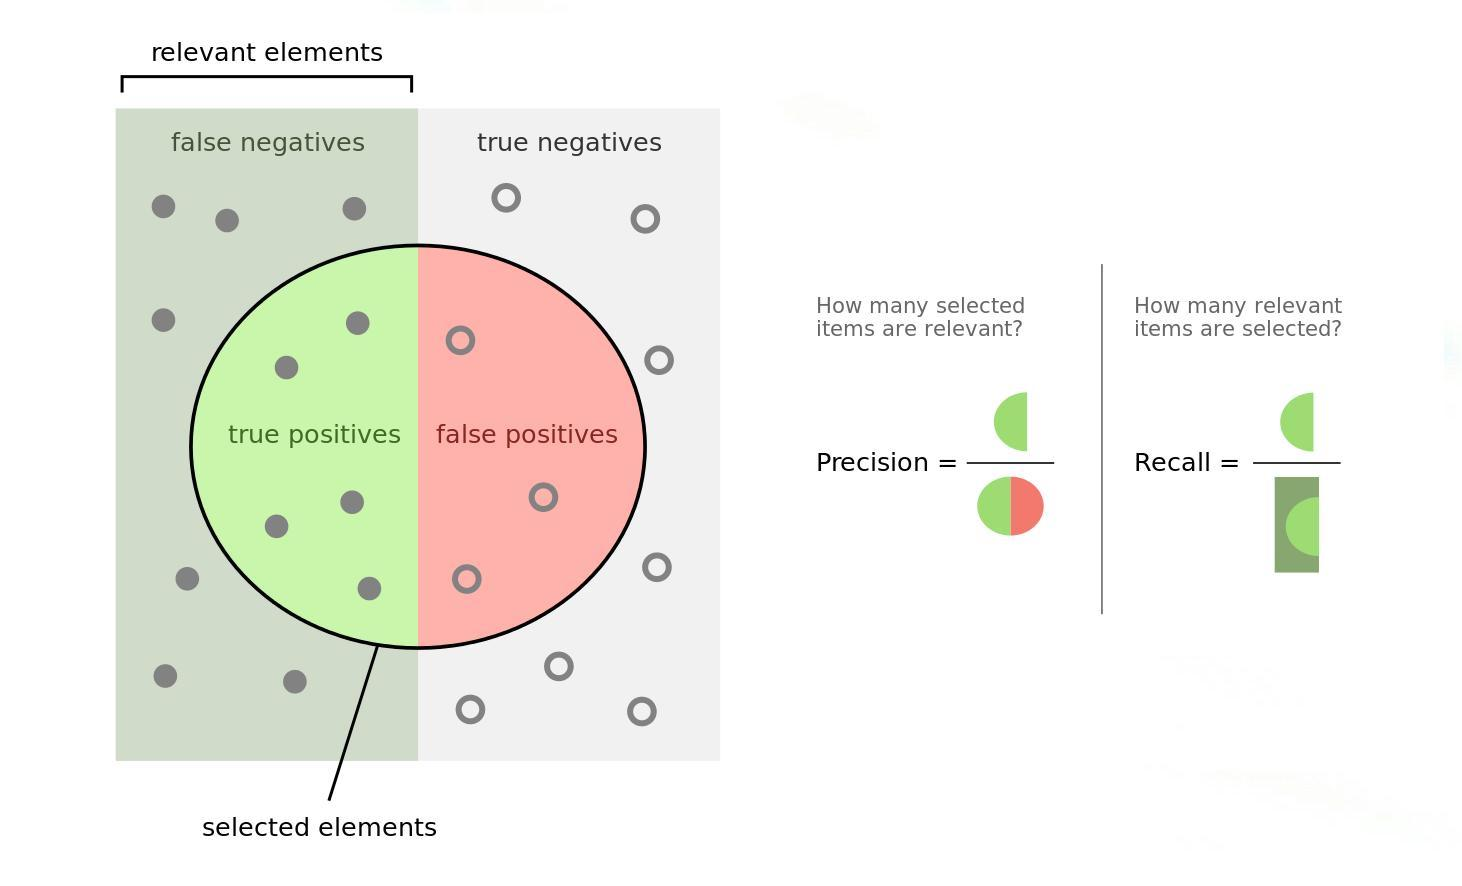
*Image by Walber - Own work, CC BY-SA 4.0, [link](https://commons.wikimedia.org/w/index.php?curid=36926283).*  

Since the survivors are very spread out, we don't expect our model to have a high recall but we would like to have a decent precision for sure.  
Note that with respect to these two metrics, the predict all die model has a score of 0.0 and 0.0!  
Let's see how these two metrics vary in a KNN model when we change the number of neighbors.

In [ ]:
cols = ["PassengerId", "Name", "Pfare", "Pclass", "Embarked"]
y_m = train_male["Survived"]
features = ["Pfare", "Pclass", "Embarked"]
X_m = train_male[features]

numerical_cols = ["Pfare"]
categorical_cols = ["Pclass", "Embarked"]

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

precision_m = []
recall_m = []

for k in range(1, 18):
    pipeline1 = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    precision_m.append(
        cross_val_score(
            pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring="precision"
        ).mean()
    )
    recall_m.append(
        cross_val_score(
            pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring="recall"
        ).mean()
    )

k_range = range(1, 18)
plt.figure(figsize=(7, 5))
plt.plot(k_range, precision_m, label="15-fold precision")
plt.plot(k_range, recall_m, label="15-fold recall")
plt.axhline(y=0.5, color="r")
plt.xlabel("Value of k for KNN")
plt.title("Precision and recall by number of neighbors", fontsize=14)
plt.legend()
plt.show()

We see that an even or odd number of neighbors makes a significant difference in the recall score, while the precision has a nice trend almost independent from the parity.  
It is interesting to see that even when the recall is approximately zero, the models maintain a non-zero precision (even though they are pretty useless).  
Let's select our three values for k in the ensemble to be 1, 3 and 7.  
The reason is that the first two are supposed to detect most of the male survivors with a decent recall while the latter is a pretty good model on his own that will improve the total precision.  
I know this is a completely naive approach to an ensemble but forgive me for this!

In [ ]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", VotingClassifier([("m1", m1), ("m2", m2), ("m3", m3)])),
    ]
)
print(
    "15-fold precision of the ensemble: {:.3f}".format(
        cross_val_score(
            male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring="precision"
        ).mean()
    )
)
print(
    "15-fold recall of the ensemble: {:.3f}".format(
        cross_val_score(
            male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring="recall"
        ).mean()
    )
)
print(
    "15-fold accuracy of the ensemble: {:.3f}".format(
        cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()
    )
)
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print("\nThe following 9 adult males are predicted to live:")
print(test_male.loc[(predictions_m == 1), cols])

The 15-fold precision of the ensemble is 0.562, slightly better than 0.5 and in between the original precisions of the three models.  
I know finding some male survivors is a difficult task, so obtaining this >0.5 accuracy is a good result for me.  
Unfortunately, the 15-fold recall of the ensemble is only 0.318 but at least it did not go down from the original recalls of the three models.  
That is a consequence of the sparsity of the survivors, especially in the second and third classes where our model was not able to extract useful patterns (except one, Mr. Ling Hee in the third class!).  
Since we made 9 predictions, there is a concrete possibility that we find some male survivors this time!  
Just for fun, here I compare the train set, how the ensemble learns it and its predictions for the test data.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
fig.suptitle("Fun comparison of train set vs test set", fontsize=14)
ax[0].set_title("Real train set")
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title("Ensemble learns the train set")
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m, ax=ax[1])
ax[2].set_title("Ensemble predicts the test set")
ax[2].set_ylim(top=60)
a = sns.swarmplot(
    x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m, ax=ax[2]
)

## Submission to Kaggle
Let's change the adult male predictions of the ensemble from the gender model and submit.  
An advantage of the new 100% public leaderboard is that we have now the possibility to count exactly how many correct predictions we make.

In [ ]:
df.loc[n_train : n_all - 1, "Predict"][
    (df.Sex == "male") & (df.WCSurvived.isnull())
] = predictions_m
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_male.csv", index=False)
print("WCG_male submission was successfully saved!")
print("Submission is loading... you scored 0.82296!")

Wow, we scored 82,3% which is 344 passengers, 3 more correct predictions than the WCG + gender model!  
It means 6 out of our 9 male predictions were correct: we finally found a way to guess some male survivors, yeah!
## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.

In [ ]:
train_female = df[:n_train].loc[
    (df.Sex == "female") & (df.WCSurvived.isnull())
]
test_female = df[n_train:].loc[
    (df.Sex == "female") & (df.WCSurvived.isnull())
]

As we did before, let's run a quick analysis to see if we can use more features or if `Age` is again not useful.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Non-WCG females EDA", fontsize=14)
sns.barplot(x="Pclass", y="Survived", data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color="r")
sns.barplot(x="Embarked", y="Survived", data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color="r")
sns.swarmplot(
    x="Pclass", y="Pfare", hue="Survived", data=train_female, ax=ax[1][0]
)
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color="y")
ax[1][0].axhline(y=10, color="y")
a = sns.swarmplot(
    y="Age", x="Pclass", hue="Survived", data=train_female, ax=ax[1][1]
)

For non-WCG females, we definitely see that `Pclass` will be determinant another time and that we have to focus on third-class because the survival rates elsewhere are really high.  
We see there is a decent concentration of green dots in the third class with `Pfare` between 7 and 10, so this may be our best chance to guess some females who died.  
Let's see `Age` and `Pfare` distributions to understand their importance.

In [ ]:
w1 = train_female.loc[train_female["Survived"] == 1, "Pfare"]
w0 = train_female.loc[train_female["Survived"] == 0, "Pfare"]
z1 = train_female.loc[train_female["Survived"] == 1, "Age"]
z0 = train_female.loc[train_female["Survived"] == 0, "Age"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Age and Pfare distributions with hue Survived", fontsize=14)
sns.distplot(w1, bins=35, label="Survived", ax=ax[0], color="c")
sns.distplot(w0, bins=15, label="Not survived", ax=ax[0], color="y")
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label="Survived", ax=ax[1], color="g")
sns.distplot(z0, bins=10, label="Not survived", ax=ax[1], color="r")
ax[1].legend()
fig.show()

We notice `Age` is again not really astonishing while `Pfare` is the one which will help us the most.  
Let's try not to use `Age` and hope for the best: we already found some male survivors so we are more than happy with the result.
## Let's build an ensemble, again
We will make our predictions through an ensemble of three models, using KNNs just for fun.  
I encourage you to fork this notebook and try your models if you don't like this choice!  
Since the classes are very imbalanced another time (the survivors are 4.5 times the deads), accuracy is not a good metric here: for example, cross-validation accuracy for the predict all live model is 0.818!  
Since sklearn metrics use 1 as the default value for positive samples, we have to create our custom metrics that use 0 as the positive value.

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score

# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

Again, we don't expect our model to have a high recall but we would like to have a decent precision.  
Note that with respect to these two custom metrics, the predict all live model has a score of 0.0 and 0.0!  
Let's vary the number of neighbors in a KNN model and see how these two quantities change.

In [ ]:
y_f = train_female["Survived"]
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1, 18):
    pipeline2 = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(
        cross_val_score(
            pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision
        ).mean()
    )
    recall_f.append(
        cross_val_score(
            pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall
        ).mean()
    )

plt.figure(figsize=(7, 5))
plt.plot(k_range, precision_f, label="9-fold precision")
plt.plot(k_range, recall_f, label="9-fold recall")
plt.axhline(y=0.5, color="r")
plt.xlabel("Value of k for KNN")
plt.title("Precision and recall by number of neighbors", fontsize=14)
plt.legend()
plt.show()

Oh, what a strange plot!  
We see the effect of parity is huge, that it takes a while to increase accuracy over 0.5 and that we have to lose almost half of the recall to gain that.  
This time, precision and recall also go to zero at the same time which is a cool thing.  
I'll try to select the KNN models with k values of 4, 9, 11 with a similar logic as before: we take the high recall of the first, we combine it to the high precision of the second and we add the third that has a little bit of both.  
Let's see how it goes...

In [ ]:
f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", VotingClassifier([("f1", f1), ("f2", f2), ("f3", f3)])),
    ]
)
print(
    "9-fold precision of the ensemble: {:.3f}".format(
        cross_val_score(
            female_pipeline, X_f, y_f, cv=9, scoring=custom_precision
        ).mean()
    )
)
print(
    "9-fold recall of the ensemble: {:.3f}".format(
        cross_val_score(
            female_pipeline, X_f, y_f, cv=9, scoring=custom_recall
        ).mean()
    )
)
print(
    "9-fold accuracy of the ensemble: {:.3f}".format(
        cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()
    )
)
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print("\nThe following 6 non-WCG females are predicted to die:")
print(test_female.loc[(predictions_f == 0), cols])

Wow, the 9-fold precision for the ensemble is 0.571, at least it did not go down!  
The recall isn't great but it's ok, also this one is a difficult task and we don't expect a lot more than this.      
I'm surprised that we made only 6 predictions, but it is what it is with such a small test set (only 97 rows).  
As I did before, here I compare the train set, how the ensemble learns it and its predictions for the test data.  
Thanks to this plot, we can also see that non-WCG females in the third class are not distributed as in the train data and this may explain why we made only a few predictions.  

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
fig.suptitle("Fun comparison of train set vs test set", fontsize=14)
ax[0].set_title("Real train set")
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title("Ensemble learns the train set")
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f, ax=ax[1])
ax[2].set_title("Ensemble predicts the test set")
ax[2].set_ylim(top=55)
a = sns.swarmplot(
    x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f, ax=ax[2]
)

It's actually pretty funny to see how the ensemble learns the train set but hey, if it works I keep it!
## Final Submission
Now it's time to see if we have a good model that predicts which females die.  
Hopefully, we have the same increment as before and have the best Titanic model ever!  
Let's change these female predictions from the previous model and submit to Kaggle.

In [ ]:
df.loc[n_train : n_all - 1, "Predict"][
    (df.Sex == "female") & (df.WCSurvived.isnull())
] = predictions_f
output = pd.DataFrame(
    {
        "PassengerId": df[891:1309].PassengerId,
        "Survived": df[891:1309].Predict.astype("int"),
    }
)
output.to_csv("WCG_male_female.csv", index=False)
print("WCG_male_female was successfully saved!")
print("Submission is loading... you scored 0.82775!")

Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  
Unfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  
Well, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      
If I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  
# Conclusion
First of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      
Secondly, thank you for reading my notebook!  
I hope you liked it: this was my attempt to push the top score higher and even if I did not succeed, it was still a nice journey.  
I had to look at the problem from another perspective and not using the `Age` column ended up being a way to find some male survivors, so at least I made an important contribution.  
This notebook proves another time that the two tasks of predicting adult male survivors and females not in a group who died are very different and it is really difficult to do both well with the same approach.  
I believe it is possible to increase the public score again ensembling this model with others, mostly to correct some of the female predictions: I think the maximum score achievable could be around 350 passengers, which is 83,7%.  
That being said, I finish this notebook with a short summary of what we did.
# Summary of what we did
This notebook proved that male survivors can be found with simple elements and thus the old top scores have the potential to be improved, especially if we use the WCG model as a strong baseline.  
Here's the pipeline we followed to reach top 1% in the competition and an histogram of Titanic LB scores in September 2020.
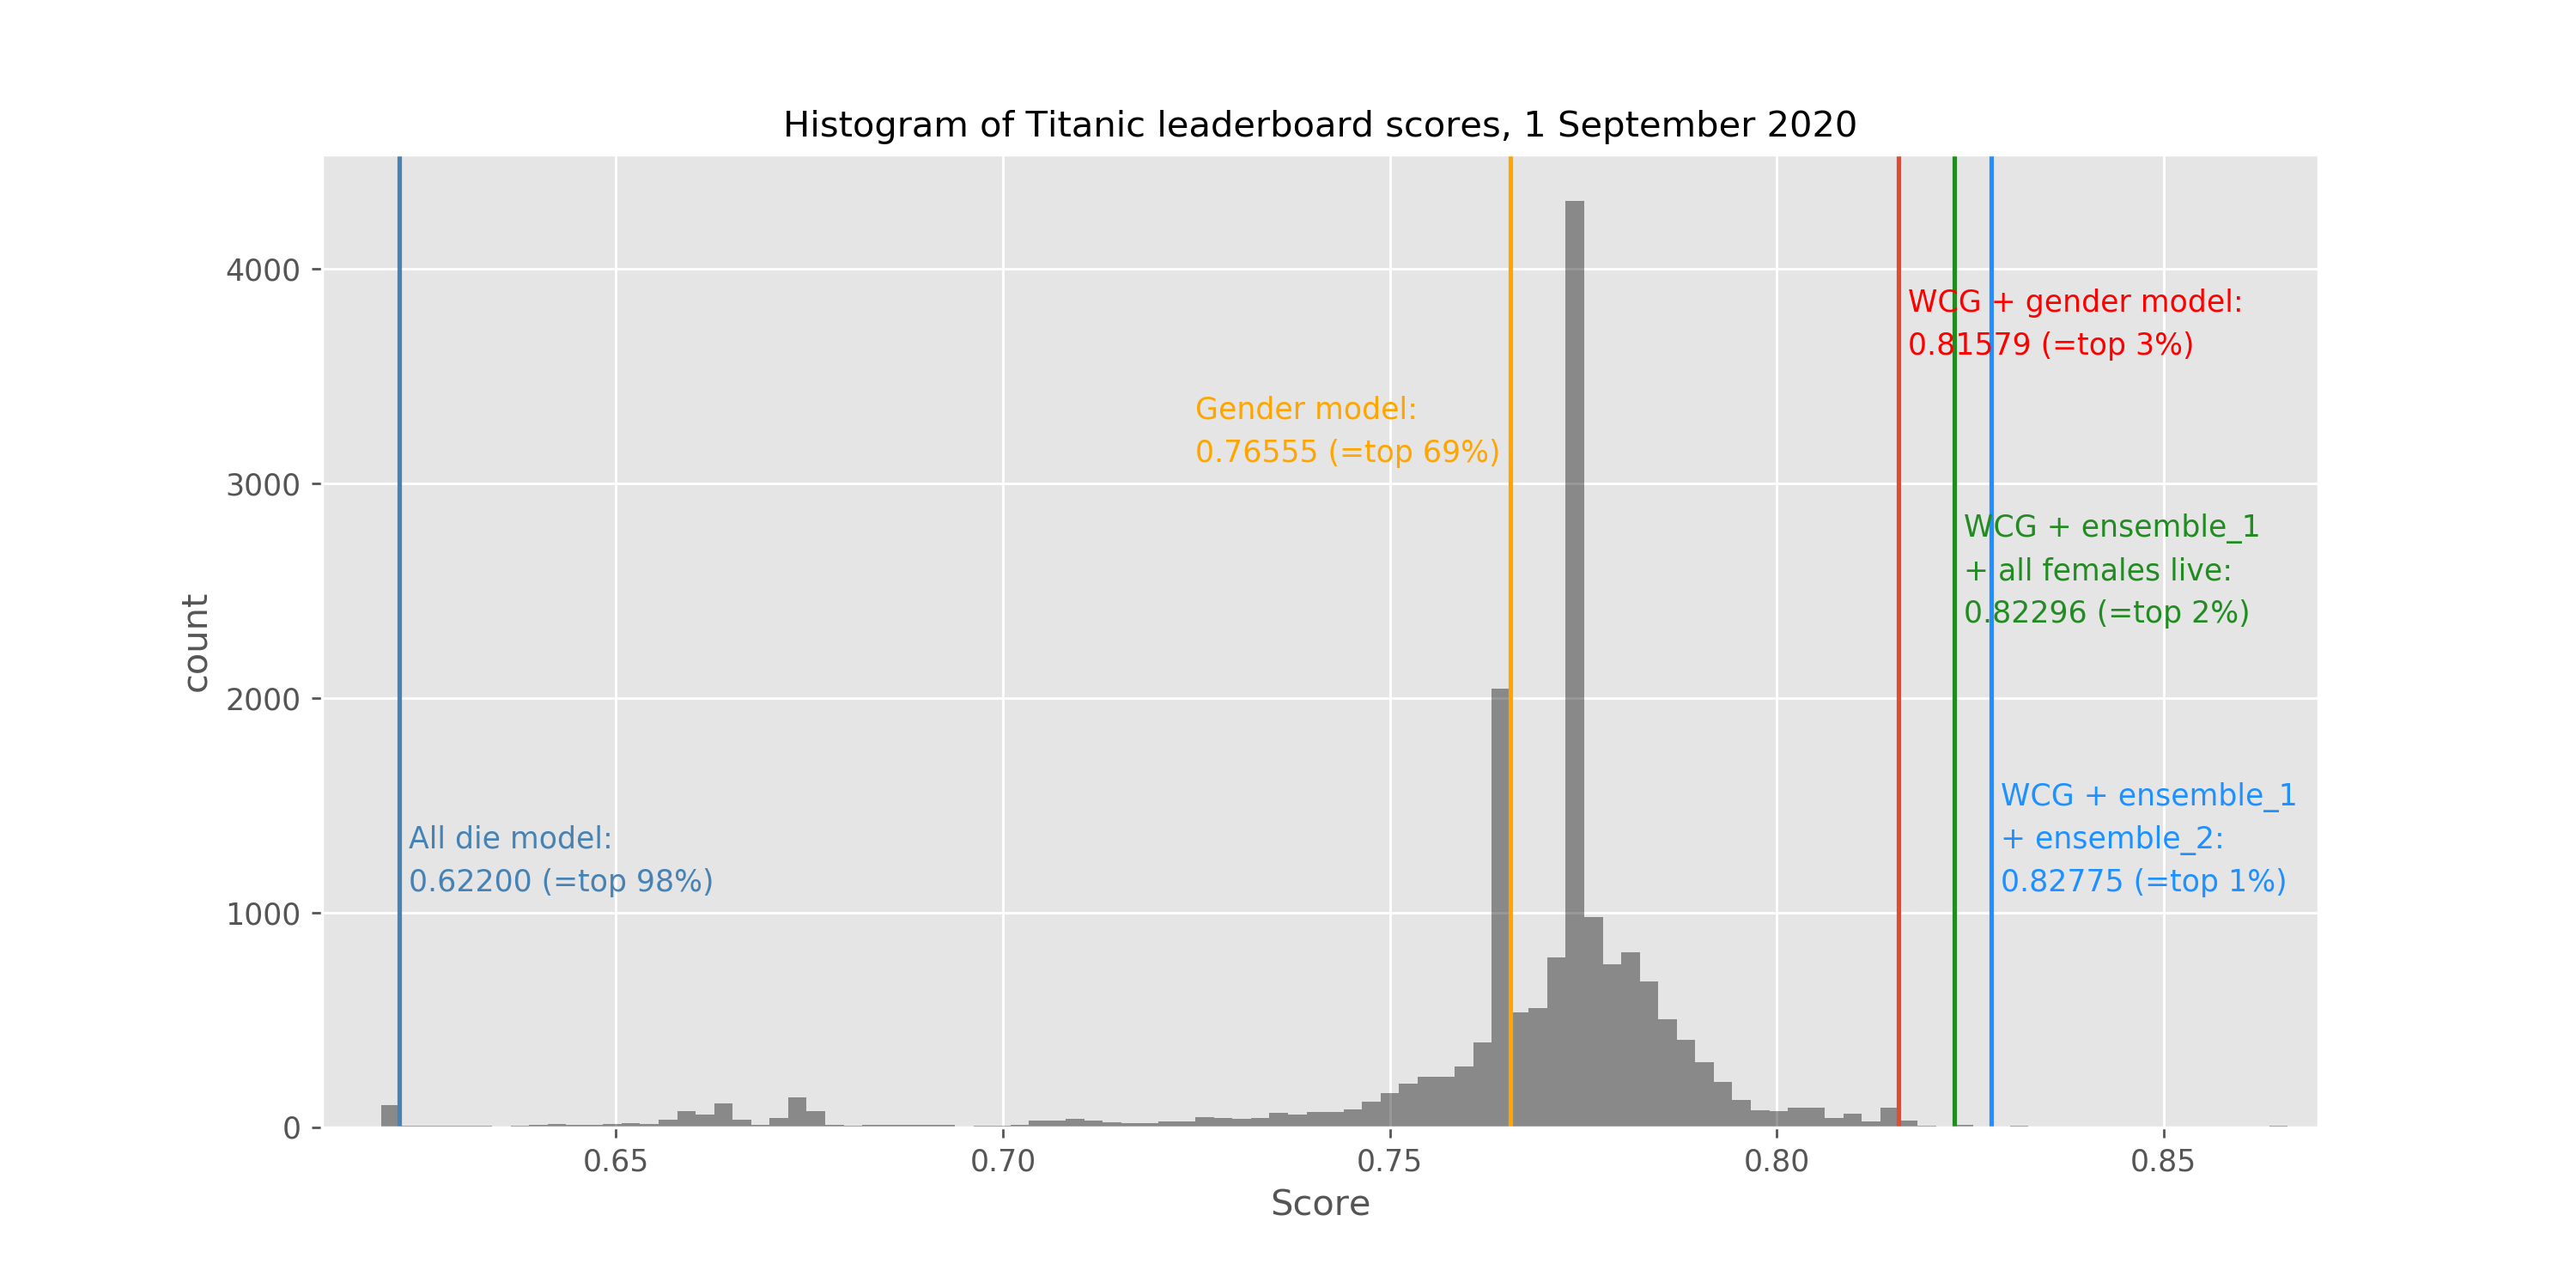
First, the passengers (train + test) were divided into four groups:
1. Adult males - 60% of the population (A)
1. Young boys (with Master title) - 5% of the population (B)
1. Females that have children, sisters, or mothers (brothers and husbands are optional) - 13% of the population (C)
1. Females that have brothers, or husbands (no children, no sisters, no mothers) or are traveling alone - 22% of the population (D)

Next, we built 3 classifiers:
1. **WCG** on top of the **gender model** to classify (B) + (C)
1. **Ensemble_1** of KNNs to classify (A)
1. **Ensemble_2** of KNNs to classify (D)

Finally we assembled the models. Here are the public scores:
1. **WCG + gender model** scores 81,6% which is 341 correct predictions
1. **WCG + ensemble_1 + all females live** scores 82,3% which is 344 correct predictions
1. **WCG + ensemble_1 + ensemble_2** scores 82,8% which is 346 correct predictions

See you soon in the next one and good luck passing 83%!  
Please let me know down in the comments your suggestions or if you find errors in the code!

# 总体思路
将所有乘客分成4类:
1. man(成年男性)
2. boy(男孩)
3. 有其他WCG成员的woman(包括成年女性与女孩)
4. 没有其他WCG成员的woman(包括成年女性与女孩)

2与3用WCG模型
1与4分别用两套"Voting of KNN模型"独立建模。

## 流程图:
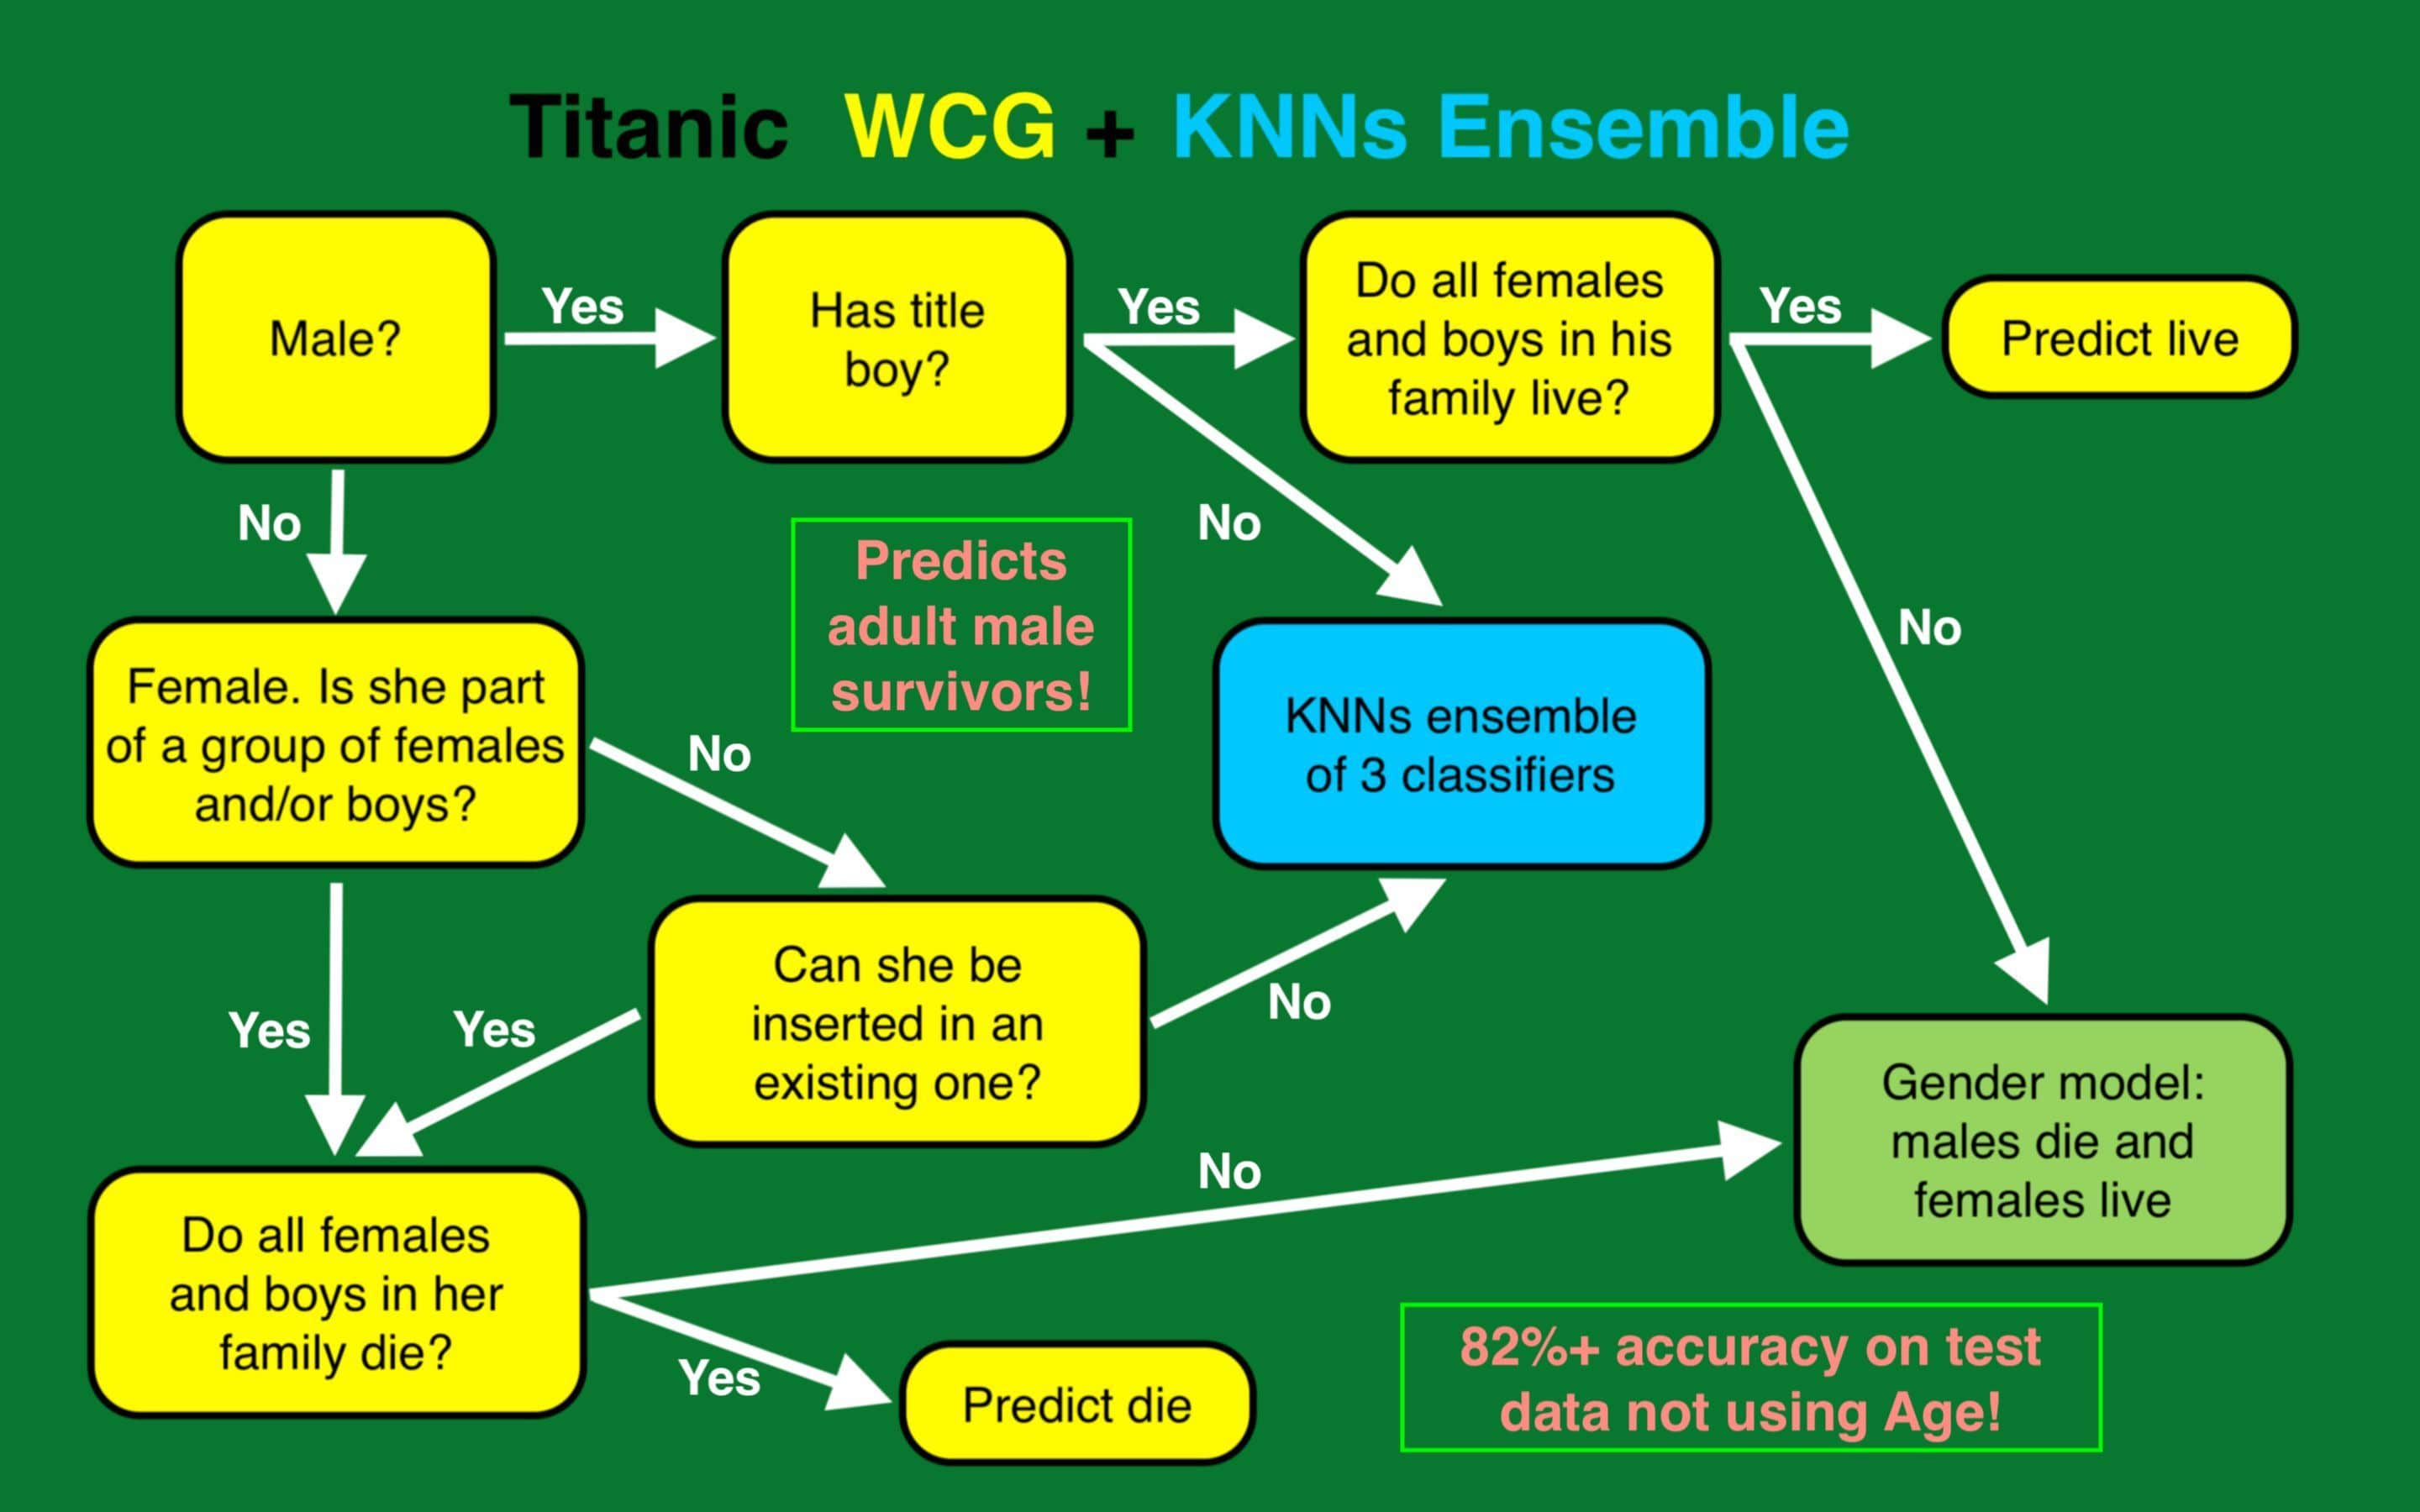

# notebook的参考
这个notebook是在[Link](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)的基础上进行改写的.